In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import random, torch.backends.cudnn as cudnn
import re
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from rtdl_revisiting_models import  FTTransformer
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset
from sklearn.metrics import r2_score, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTENC
from tabm import TabM, EnsembleView, make_tabm_backbone, LinearEnsemble


In [2]:
df = pd.read_csv("convert_json_data.csv")
# df = df.iloc[:50_000].copy()
LABEL_ONLY_COLS = ["category_group"]
CATEGORICAL_FEATURES = [        
    'currency',
    'country_displayable_name',
    'location_state',
    "dur_bin",
]
NUMERIC_FEATURES = [
    # # seasonality / timing
    # "year_launched_at","month_launched_at","day_launched_at","launch_dow",
    # "deadline_dow","launched_at_mon_sin","launched_at_mon_cos",
    # "launched_at_dom_sin","launched_at_dom_cos",
    # "deadline_mon_sin","deadline_mon_cos","deadline_dom_sin","deadline_dom_cos",
    # "prep_days","days_diff_launched_at_deadline","days_diff_launched_at_deadline_log","too_short_or_long",
    # # text/media
    # "name_len","blurb_len","has_video","has_photo",
    # # goal scale
    # "goal_usd","goal_usd_log","goal_per_day","goal_per_day_log",
    # "goal_round_100","goal_round_1000","goal_last2","goal_end_00","goal_end_99","goal_k_bucket",
    
    # # ranks / group-relative (no pledged)
    # "gpd_rank_in_cat","gpd_vs_cat_median","gpd_dist_cat_median","log1p_gpd_vs_cat_med",
    # "goal_rank_in_cat","goal_vs_cat_median","goal_vs_country_median",
    # "gpd_rank_in_cat_mon","goal_rank_in_cat_mon","goal_vs_cat_country_med","gpd_vs_cat_country_med",
    # "gpd_rank_cat_dur","gpd_vs_catdur_med",
    # # 30-day density
    # "cat_30d_launch_density","cat_30d_density_rank","cat_30d_density_z",
    # # group stats (goal-only)
    # "cat_mon_n","cat_mon_goal_med","cat_mon_gpd_med",
    
        # seasonality / timing (ใช้เวอร์ชัน cyclic เป็นหลัก)
    "launch_dow", "deadline_dow",
    "prep_days",
    "days_diff_launched_at_deadline","days_diff_launched_at_deadline_log",
    "too_short_or_long",

    # text/media
    "name_len","blurb_len","has_video","has_photo",

    # goal scale -> เก็บเฉพาะเวอร์ชัน log เพื่อลดซ้ำซ้อน
    "goal_usd_log","goal_per_day_log",
    
    # เลือกไม่กี่ตัวที่ “เป็นตัวแทน” จริง ๆ เพื่อลดซ้ำซ้อน
    "gpd_rank_in_cat_mon",     # เลือก rank ใน cat x month
    "goal_rank_in_cat_mon",
    "gpd_vs_cat_country_med",  # เลือก vs median สาย cat x country
    "goal_vs_cat_country_med",
    
    # 30-day density (ต่อหมวด-เวลา)
    "cat_30d_launch_density",
    "cat_30d_density_z",

    # group stats (goal-only) ต่อหมวด-เดือน
    "cat_mon_n","cat_mon_goal_med","cat_mon_gpd_med",
    
]
CYCLIC_NUMERIC = [ 
    'deadline_mon_sin',
    'deadline_mon_cos',
    'deadline_dom_sin',
    'deadline_dom_cos',  
    'launched_at_mon_sin',
    'launched_at_mon_cos',
    'launched_at_dom_sin',
    'launched_at_dom_cos',  
]

FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

In [3]:
label_encoders = {}
for col in CATEGORICAL_FEATURES:
    df[col] = df[col].fillna("missing").astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
for col in LABEL_ONLY_COLS:
    df[col] = df[col].fillna("missing").astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col]) 
    label_encoders[col] = le

In [4]:
TARGET_FEATURE = {
    "success_cls": df["state"].to_numpy(dtype=np.int64),
    # "success_rate_cls": df["success_rate_cls"].to_numpy(dtype=np.int64),
    "risk_level": df["risk_level"].to_numpy(dtype=np.int64),
    "days_to_state_change": df["duration_class"].to_numpy(dtype=np.int64),
    "recommend_category": df["category_group"].to_numpy(dtype=np.int64),
    "goal_eval": df["goal_eval"].to_numpy(dtype=np.int64),
    # "shortfall_severity_cls": df["shortfall_severity_cls"].to_numpy(dtype=np.int64),
    "stretch_potential_cls": df["stretch_potential_cls"].to_numpy(dtype=np.int64),
}

key = df["category_group"].astype(str) + "_" + df["state"].astype(str)
# idx_train, idx_val = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42, stratify=key)
idx_train, idx_val = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42)
X_train_df = df.iloc[idx_train]
X_val_df = df.iloc[idx_val]




==== success_cls ====


C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\U

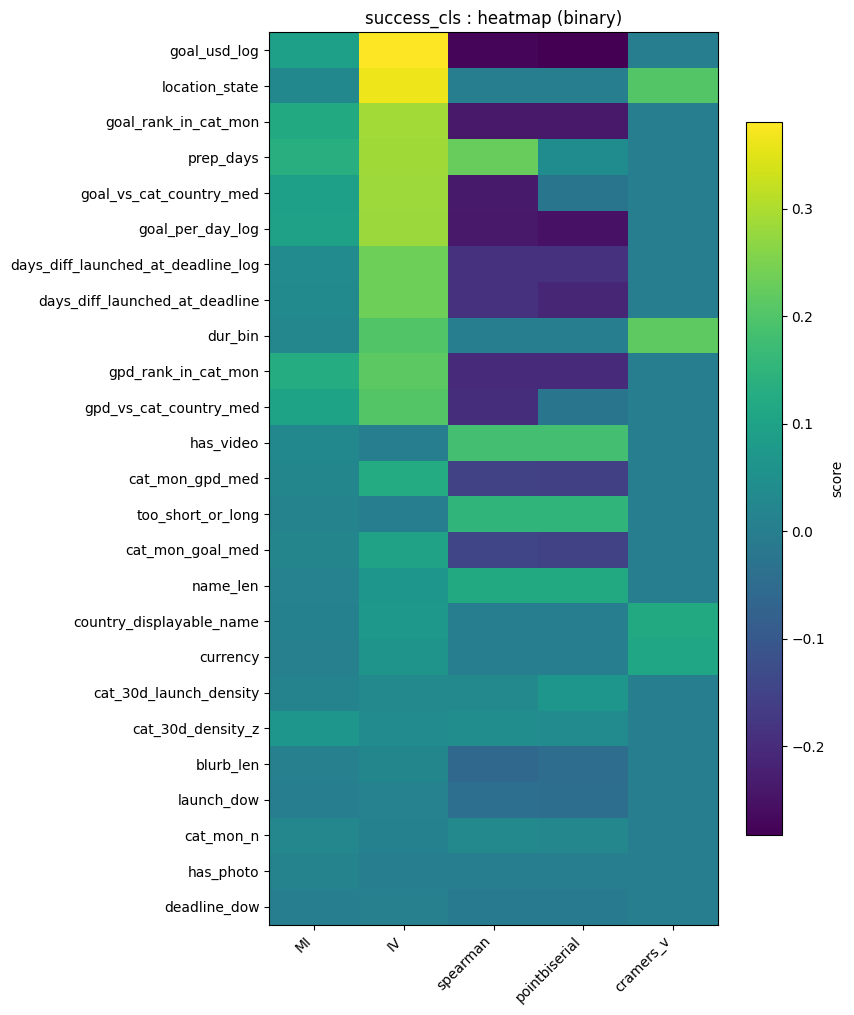

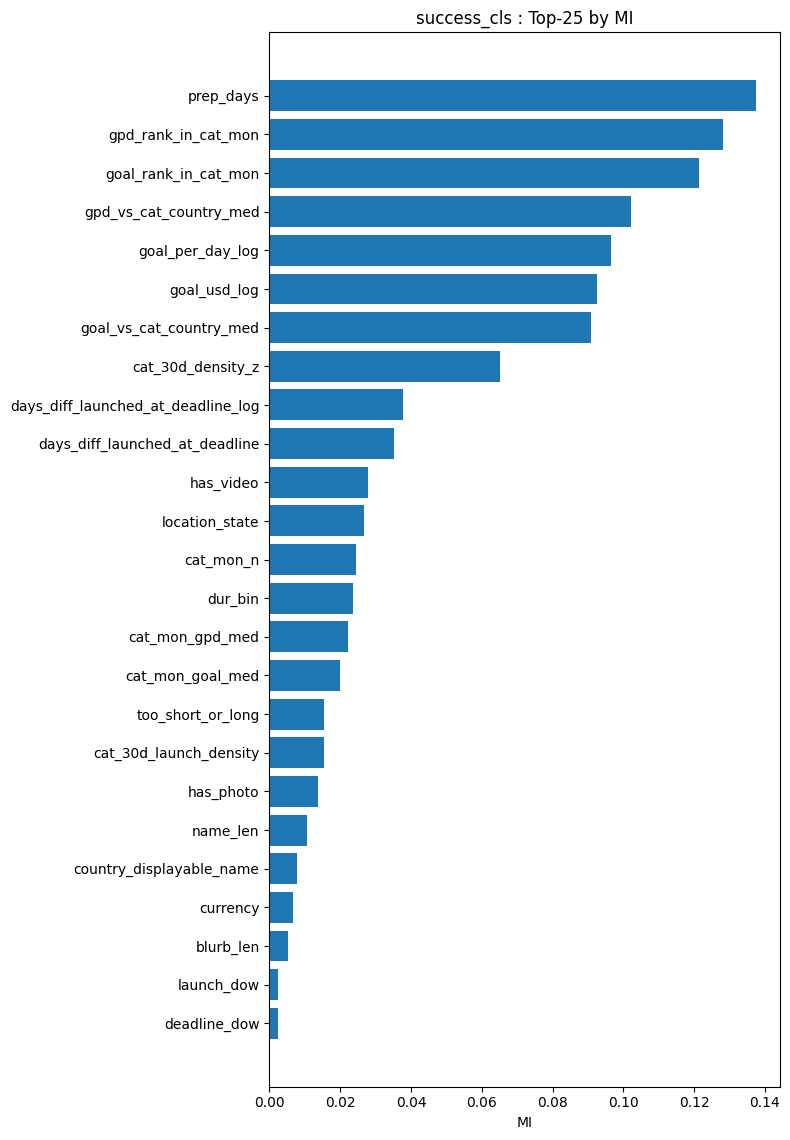


==== risk_level ====


C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\U

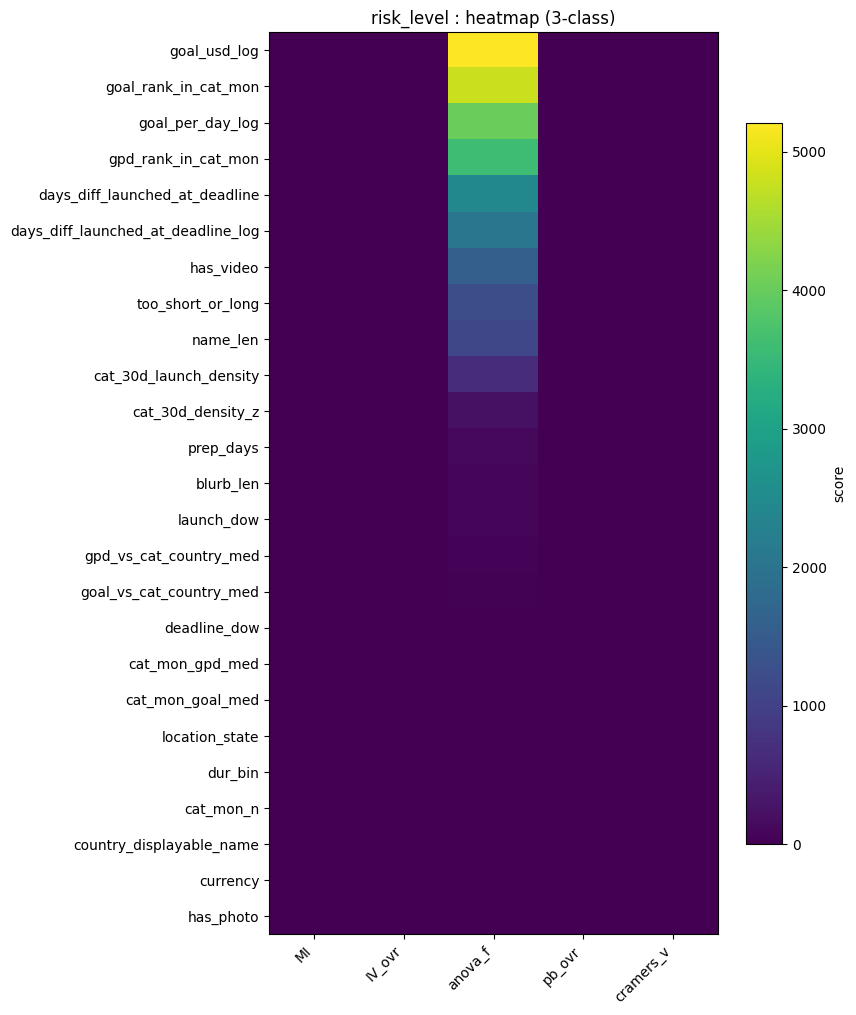

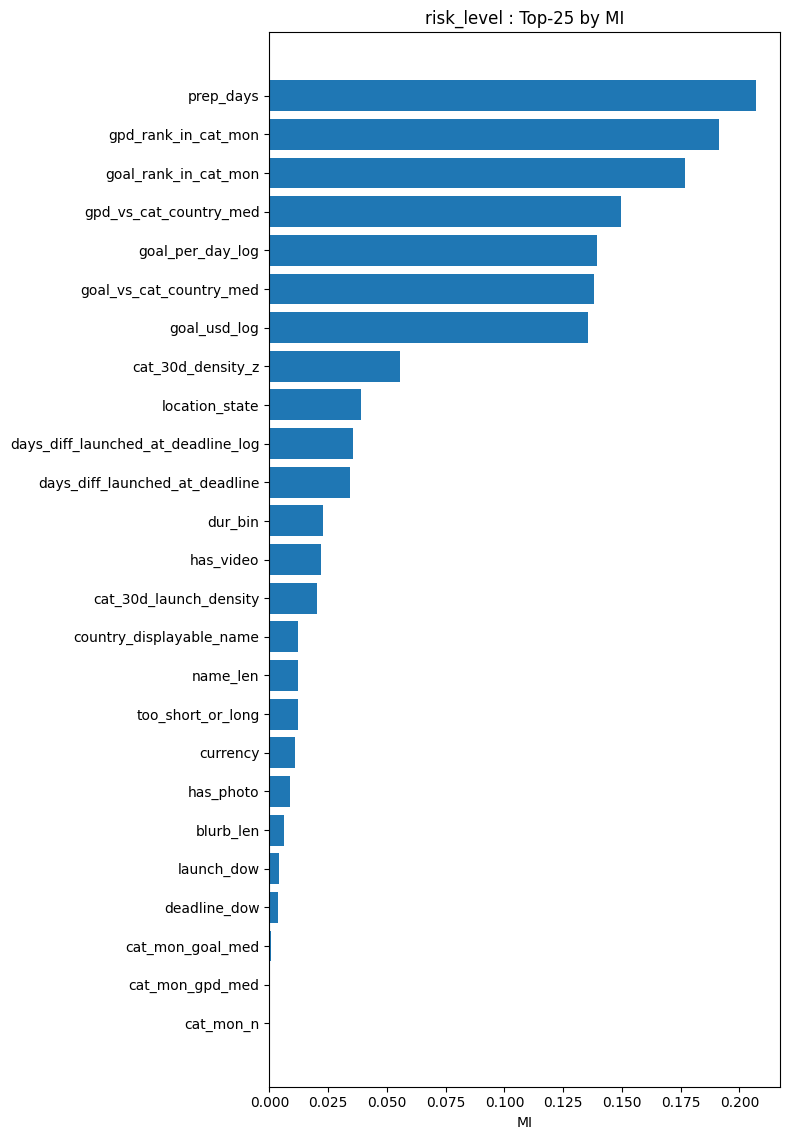


==== days_to_state_change ====


C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\U

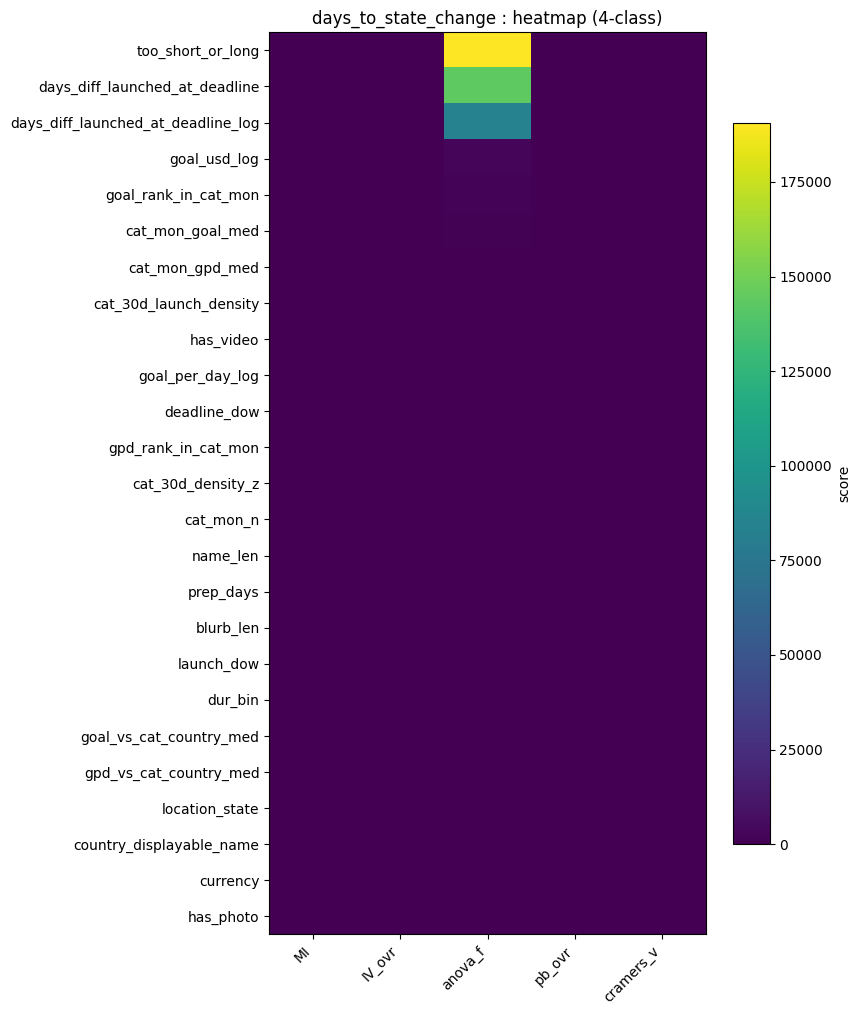

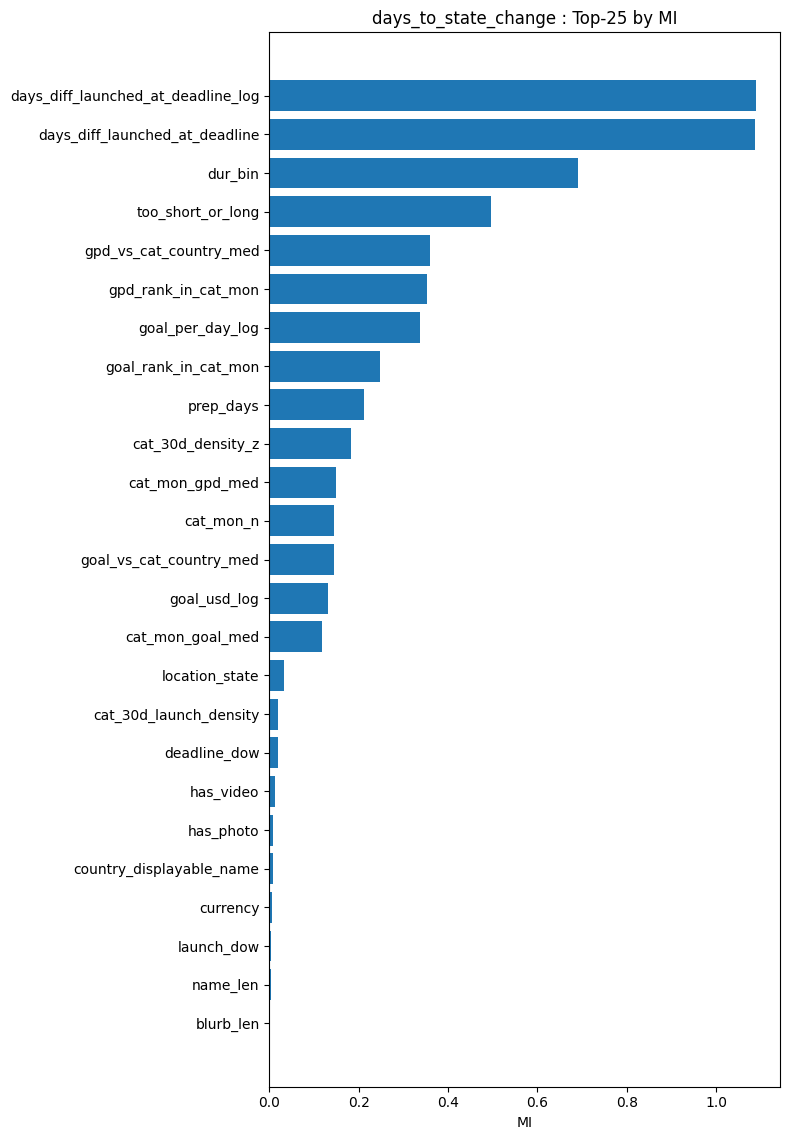


==== recommend_category ====


C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\U

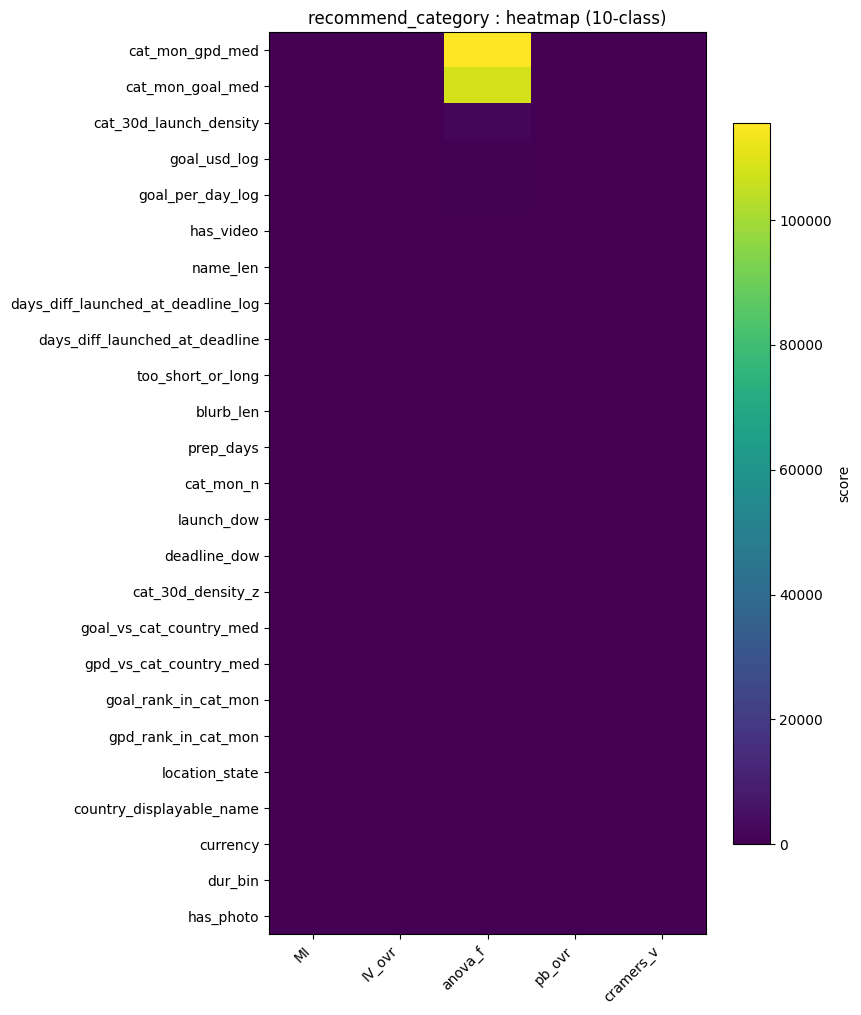

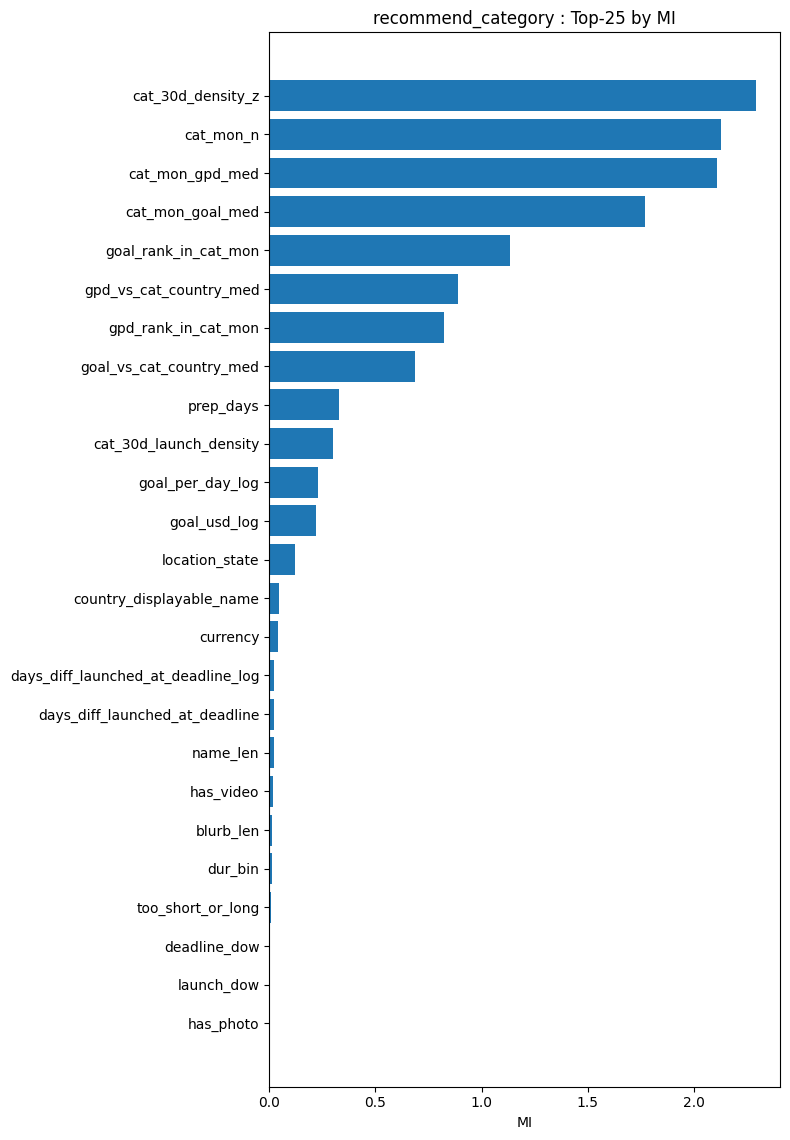


==== goal_eval ====


C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\U

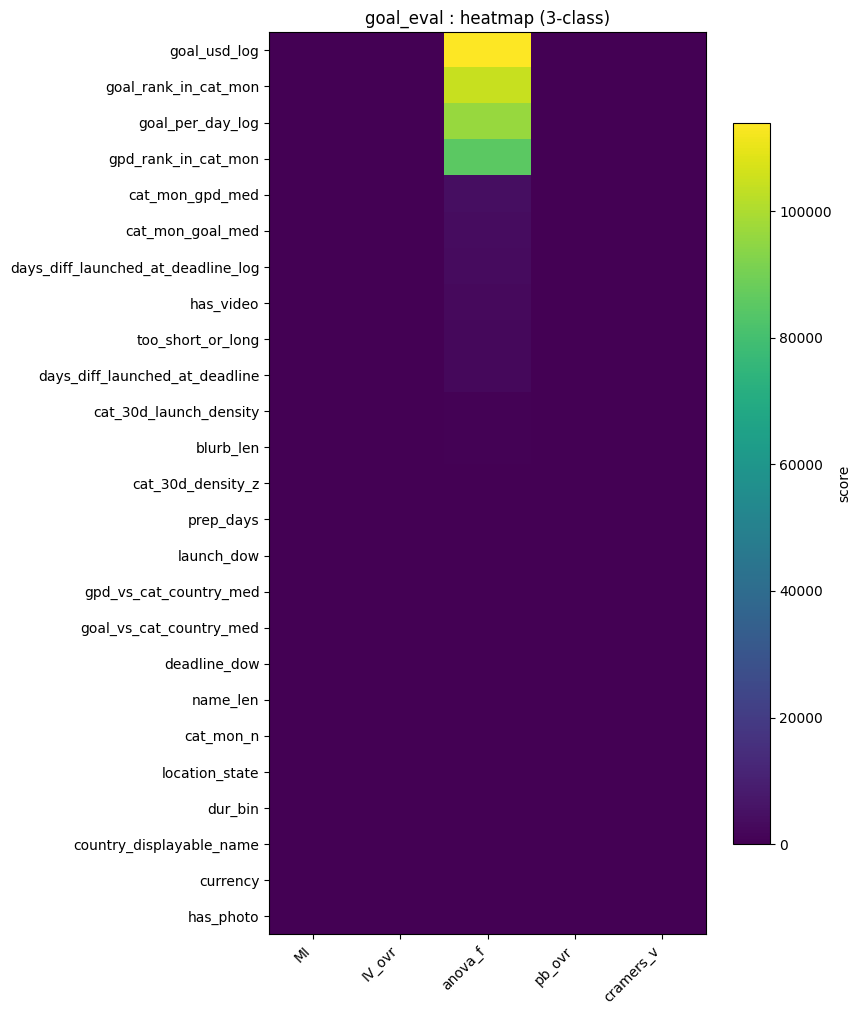

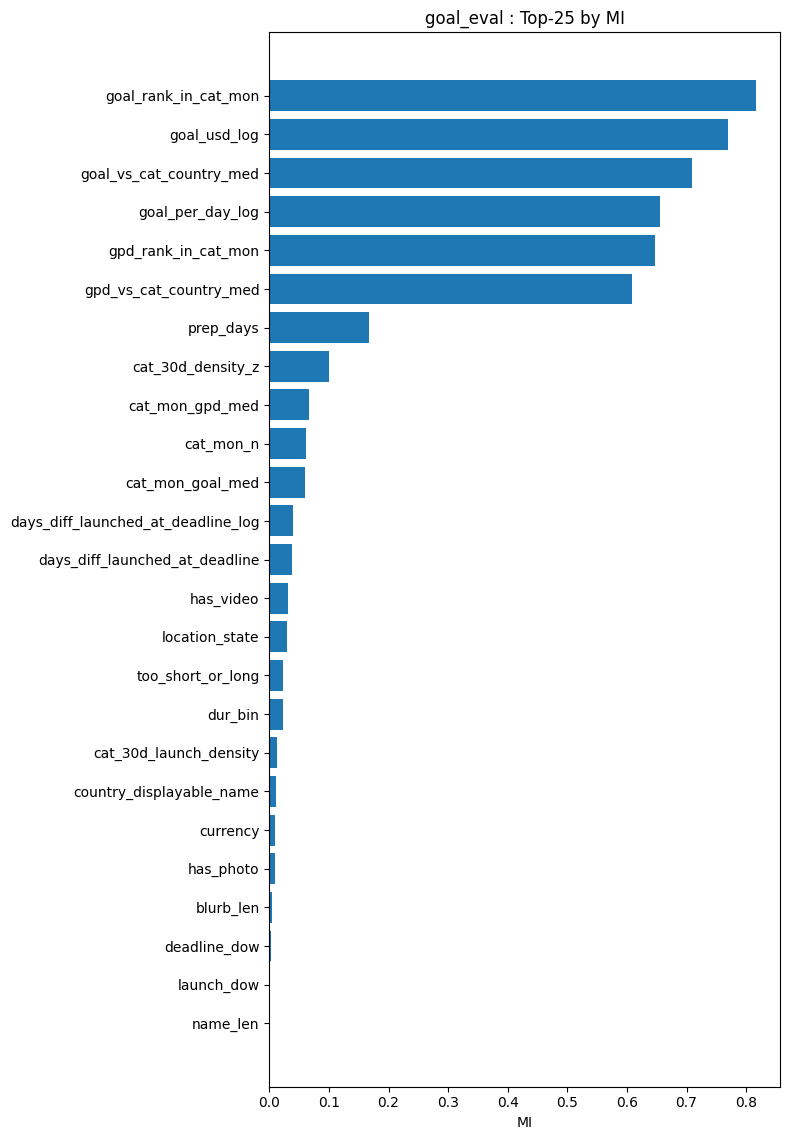


==== stretch_potential_cls ====


C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby("x")["y"]
C:\Users\U

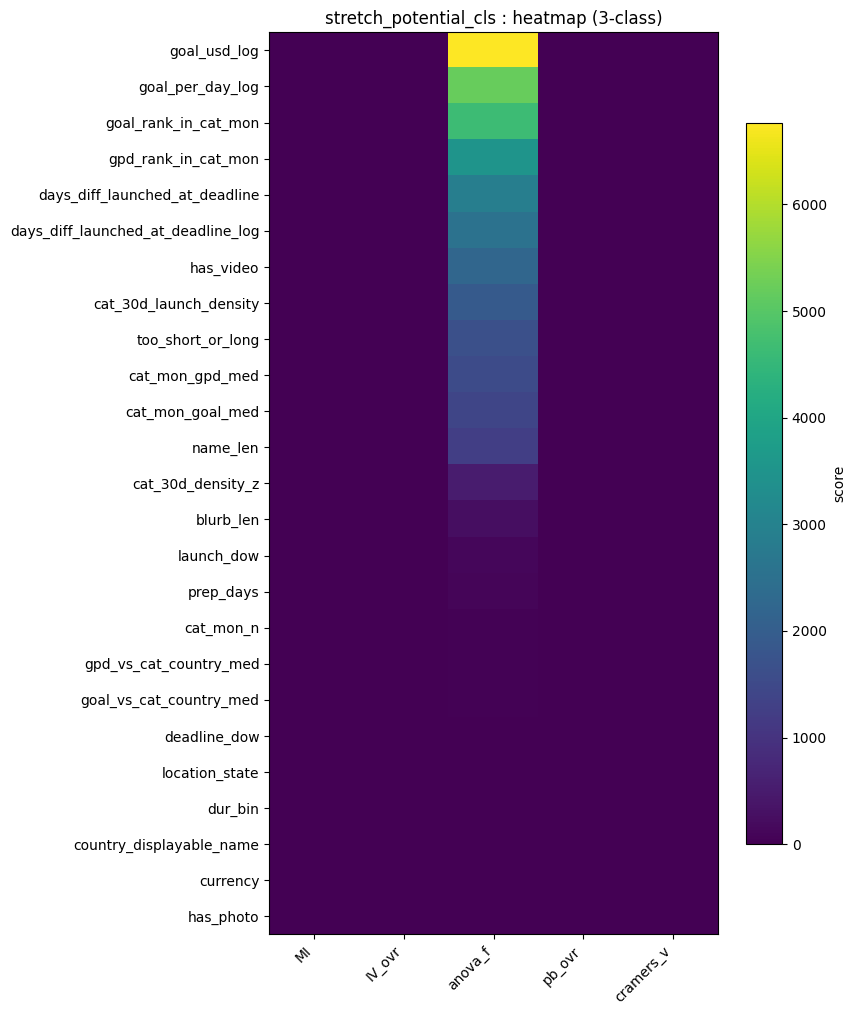

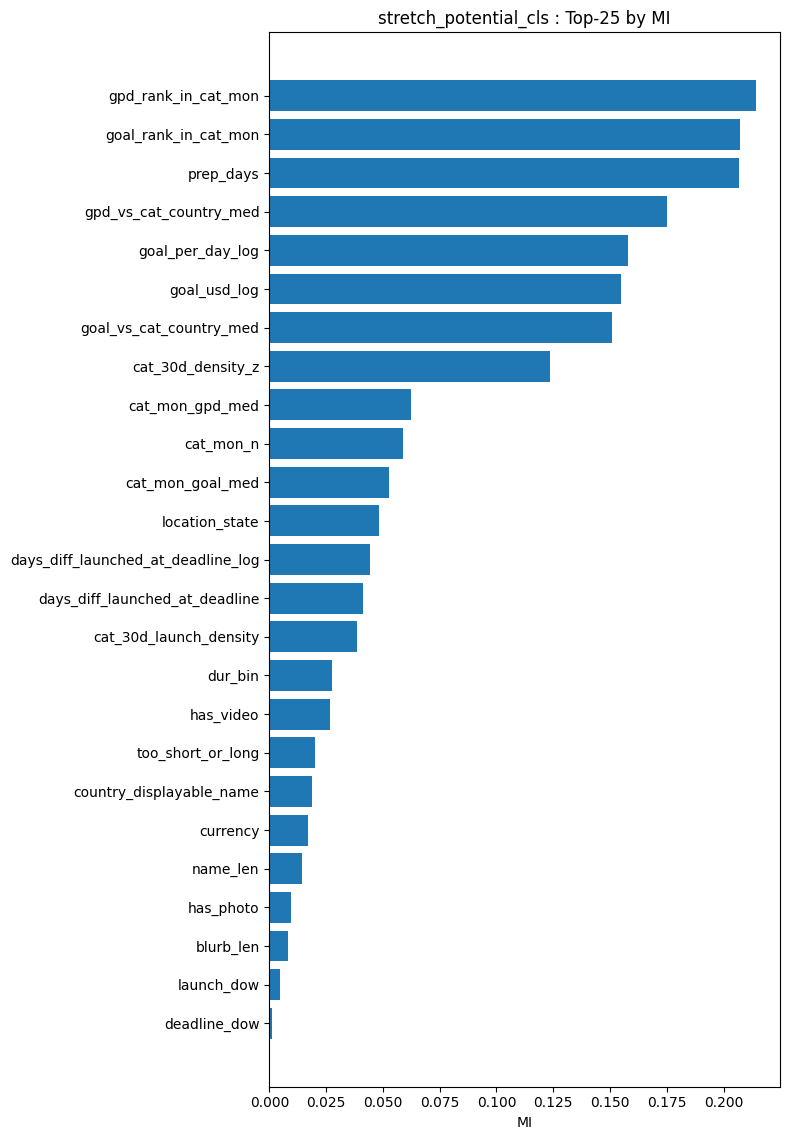

C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:166: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin")["y"].agg(["mean","count"])


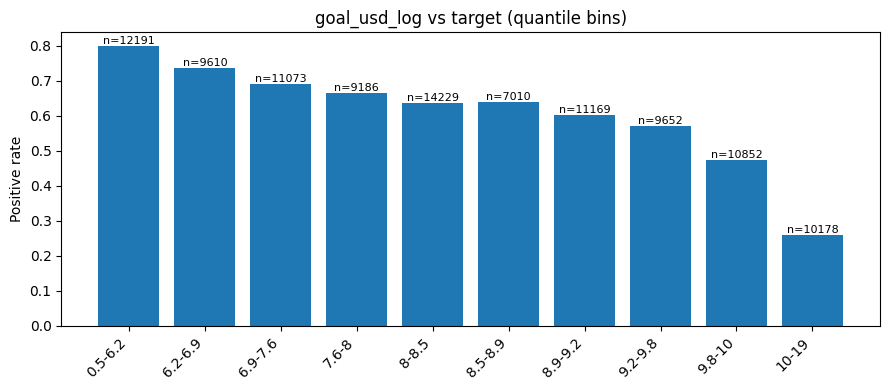

C:\Users\USER\AppData\Local\Temp\ipykernel_28236\777088286.py:187: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=[str(c) for c in top], showfliers=False)


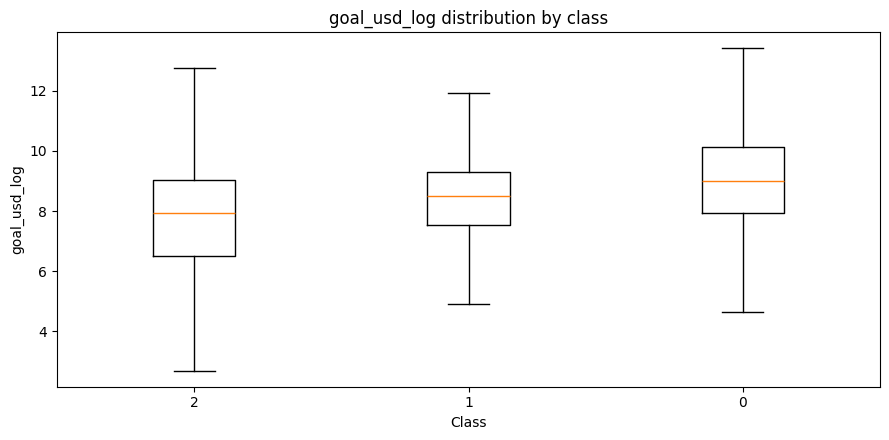

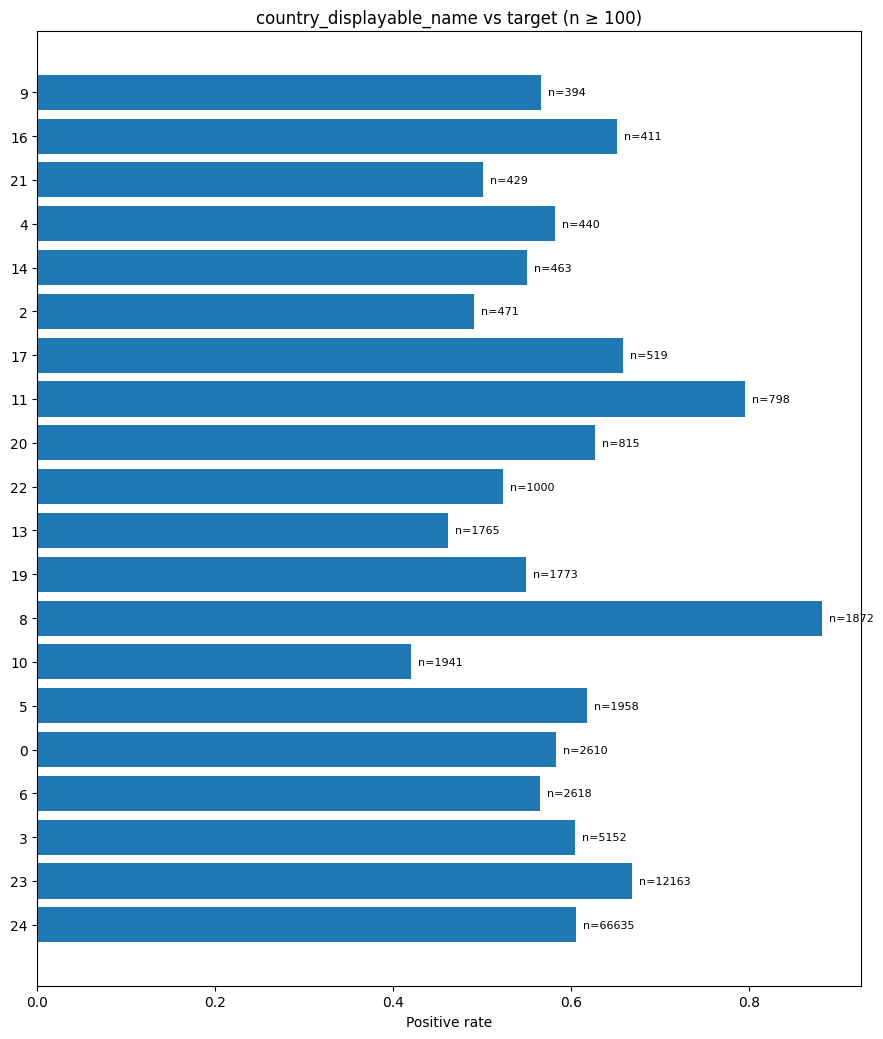

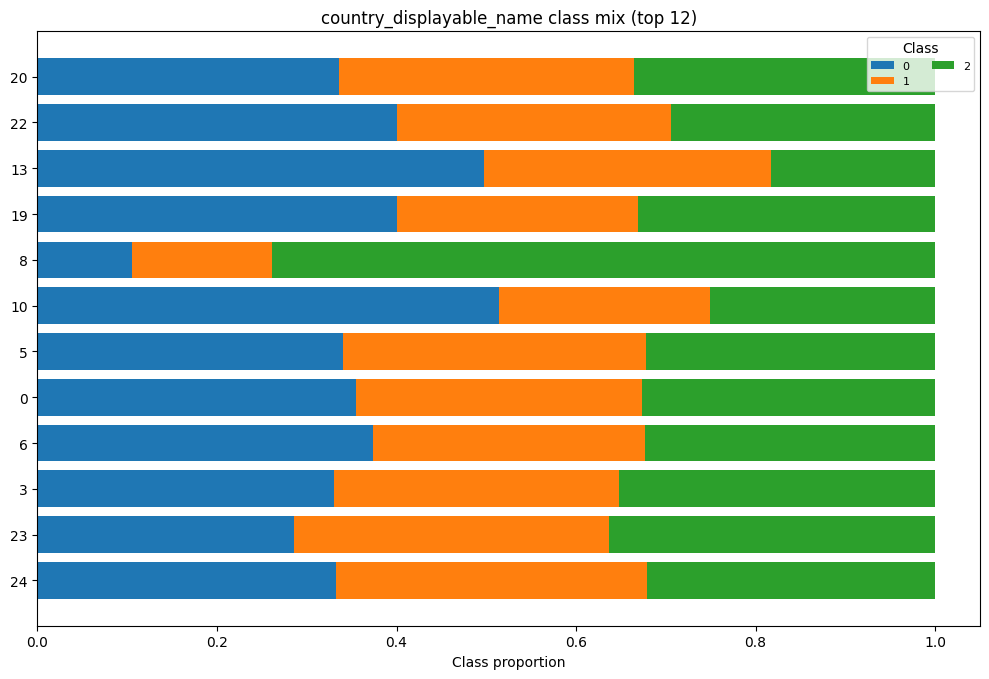

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import spearmanr, pointbiserialr, chi2_contingency

# ========= helpers (เหมือนเดิม + เพิ่ม multi-class) =========
def cramers_v(x, y):
    tbl = pd.crosstab(x, y)
    if tbl.size == 0: return 0.0
    chi2, _, _, _ = chi2_contingency(tbl)
    n = tbl.values.sum()
    if n <= 1: return 0.0
    phi2 = chi2 / n
    r, k = tbl.shape
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    denom = max(1e-12, min(k_corr-1, r_corr-1))
    return float(np.sqrt(phi2_corr / denom))

def info_value_binary(x, y, nbins=10):
    s = pd.Series(x)
    if pd.api.types.is_numeric_dtype(s):
        try:
            s = pd.qcut(s, q=nbins, duplicates='drop')
        except Exception:
            s = pd.cut(s, bins=nbins)
    df_ = pd.DataFrame({"x": s, "y": y})
    g = df_.groupby("x")["y"]
    bad  = (g.mean() * g.count()).fillna(0.0)    # y=1
    good = ((1 - g.mean()) * g.count()).fillna(0.0)  # y=0
    bad  = bad  / max(bad.sum(), 1.0)
    good = good / max(good.sum(), 1.0)
    woe = np.log((bad + 1e-9) / (good + 1e-9))
    iv = ((bad - good) * woe).sum()
    return float(iv)

def info_value_ovr(x, y, nbins=10):  # macro |IV| บน one-vs-rest
    classes = pd.unique(y)
    vals = []
    for c in classes:
        yb = (y == c).astype(int)
        try:
            vals.append(abs(info_value_binary(x, yb, nbins=nbins)))
        except Exception:
            continue
    return float(np.mean(vals)) if len(vals) else np.nan

def pointbiserial_ovr(x, y):  # macro |r_pb| บน one-vs-rest
    x = pd.to_numeric(pd.Series(x), errors='coerce')
    maskx = x.notna().values
    y = np.asarray(y)
    classes = np.unique(y[maskx])
    vals = []
    for c in classes:
        yb = (y == c).astype(int)[maskx]
        r = pointbiserialr(yb, x[maskx]).correlation
        if np.isfinite(r): vals.append(abs(r))
    return float(np.mean(vals)) if len(vals) else np.nan

def ensure_int_labels(y):
    """คืน np.ndarray(int64) + จำนวนคลาส"""
    y = pd.Series(y)
    if not np.issubdtype(y.dtype, np.integer):
        y = pd.factorize(y, sort=True)[0]
    return y.astype(np.int64), int(pd.Series(y).nunique())

# ========= ตารางสรุปความสัมพันธ์ (auto เลือก metric ตามชนิด target) =========
def feature_target_report(df, target, numeric_features, categorical_features, topk_MI=200):
    y, ncls = ensure_int_labels(target)
    cols = list(numeric_features) + list(categorical_features)

    # เตรียมสำหรับ MI
    X_mi = pd.DataFrame(index=df.index)
    for c in numeric_features:
        X_mi[c] = pd.to_numeric(df[c], errors='coerce').fillna(df[c].median())
    for c in categorical_features:
        X_mi[c] = df[c].astype('category').cat.codes  # NaN -> -1
    discrete_mask = X_mi.columns.isin(categorical_features)
    mi = mutual_info_classif(X_mi.values, y, discrete_features=discrete_mask, random_state=0)

    rows = []
    for i, c in enumerate(X_mi.columns):
        row = {"feature": c, "feat_type": "cat" if c in categorical_features else "num", "MI": mi[i]}

        if c in numeric_features:
            x = pd.to_numeric(df[c], errors='coerce')
            if ncls == 2:
                # binary metrics
                sp = spearmanr(x, y, nan_policy='omit')
                row["spearman"] = float(sp.correlation) if np.isfinite(sp.correlation) else np.nan
                mask = x.notna()
                if mask.any():
                    pb = pointbiserialr(y[mask], x[mask])
                    row["pointbiserial"] = float(pb.correlation) if np.isfinite(pb.correlation) else np.nan
                else:
                    row["pointbiserial"] = np.nan
                row["IV"] = info_value_binary(x, y)
            else:
                # multi-class metrics
                try:
                    F, p = f_classif(x.values.reshape(-1,1), y)
                    row["anova_f"] = float(F[0]) if np.isfinite(F[0]) else np.nan
                except Exception:
                    row["anova_f"] = np.nan
                row["pb_ovr"]  = pointbiserial_ovr(x, y)     # macro abs
                row["IV_ovr"]  = info_value_ovr(x, y)
        else:
            # categorical feature
            row["cramers_v"] = cramers_v(df[c].astype(str), y)
            if ncls == 2:
                row["IV"] = info_value_binary(df[c].astype(str), y)
            else:
                row["IV_ovr"] = info_value_ovr(df[c].astype(str), y)
        rows.append(row)

    rep = pd.DataFrame(rows).sort_values("MI", ascending=False)
    return rep.head(topk_MI), ncls

# ========= PLOTS =========
def plot_feature_metric_heatmap(report, metrics=("MI",), topk=30, annotate=False, title=None):
    rep = report.copy()
    mcols = [m for m in metrics if m in rep.columns]
    if not mcols:
        print("No metrics found to plot."); return report.head(0)
    rep["_max_abs"] = rep[mcols].abs().max(axis=1)
    rep = rep.sort_values(["_max_abs","MI"], ascending=False).head(topk)
    M = np.nan_to_num(rep[mcols].to_numpy(), nan=0.0)

    fig_h = max(2.5, 0.35*len(rep) + 1.5)
    fig_w = max(5.0, 1.2*len(mcols) + 2.5)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(M, aspect='auto')
    ax.set_xticks(np.arange(len(mcols))); ax.set_xticklabels(mcols, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(rep)));   ax.set_yticklabels(rep["feature"].tolist())
    ax.set_title(title if title else "Feature–Target relationship")
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.set_ylabel("score", rotation=90)
    if annotate:
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                ax.text(j, i, f"{M[i,j]:.2f}", ha='center', va='center', fontsize=8)
    fig.tight_layout(); plt.show()
    return rep[["feature"] + mcols]

def plot_topk_metric_bar(report, metric="MI", k=20, title=None):
    if metric not in report.columns:
        print(f"Metric {metric} not in report."); return
    dfp = (report[["feature", metric]].dropna()
           .sort_values(metric, ascending=False).head(k).iloc[::-1])
    fig, ax = plt.subplots(figsize=(8, max(2.5, 0.4*k + 1.5)))
    ax.barh(dfp["feature"], dfp[metric])
    ax.set_xlabel(metric)
    ax.set_title(title if title else f"Top {k} features by {metric}")
    fig.tight_layout(); plt.show()

def plot_numeric_target_profile(df, feature, target, q=10):
    # สำหรับ binary target
    s = pd.to_numeric(df[feature], errors='coerce')
    y = pd.Series(target).astype(int)
    mask = s.notna() & y.notna()
    if mask.sum() == 0: return
    bins = pd.qcut(s[mask], q=q, duplicates='drop')
    tmp = pd.DataFrame({"bin": bins, "y": y[mask].values})
    g = tmp.groupby("bin")["y"].agg(["mean","count"])
    labels = [f"{iv.left:.2g}-{iv.right:.2g}" for iv in g.index.astype('interval')]
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.bar(np.arange(len(g)), g["mean"].values)
    ax.set_xticks(np.arange(len(g))); ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel("Positive rate")
    ax.set_title(f"{feature} vs target (quantile bins)")
    for i, n in enumerate(g["count"].values):
        ax.text(i, g["mean"].values[i], f"n={int(n)}", ha='center', va='bottom', fontsize=8)
    fig.tight_layout(); plt.show()

def plot_numeric_vs_multiclass(df, feature, target, max_classes=10):
    # boxplot ของค่า feature แยกตามคลาส
    s = pd.to_numeric(df[feature], errors='coerce')
    y = pd.Series(target)
    tmp = pd.DataFrame({"x": s, "y": y}).dropna()
    if tmp.empty: return
    # จำกัด top classes ตามจำนวนตัวอย่าง
    top = tmp["y"].value_counts().index[:max_classes]
    data = [tmp.loc[tmp["y"]==c, "x"].values for c in top]
    fig, ax = plt.subplots(figsize=(9, 4.5))
    ax.boxplot(data, labels=[str(c) for c in top], showfliers=False)
    ax.set_xlabel("Class"); ax.set_ylabel(feature)
    ax.set_title(f"{feature} distribution by class")
    fig.tight_layout(); plt.show()

def plot_categorical_target_rate_binary(df, feature, target, min_count=50, top_k=20):
    tmp = df[[feature]].copy()
    tmp["y"] = pd.Series(target).astype(int).values
    tmp = tmp[tmp[feature].notna()]
    g = tmp.groupby(feature)["y"].agg(['mean','count']).sort_values('count', ascending=False)
    g = g[g['count'] >= min_count].head(top_k)
    if g.empty: return
    fig, ax = plt.subplots(figsize=(9, max(2.5, 0.45*len(g)+1.5)))
    ax.barh(g.index.astype(str), g["mean"].values)
    ax.set_xlabel("Positive rate"); ax.set_title(f"{feature} vs target (n ≥ {min_count})")
    for i, (m, n) in enumerate(zip(g["mean"].values, g["count"].values)):
        ax.text(m, i, f"  n={int(n)}", va='center', ha='left', fontsize=8)
    fig.tight_layout(); plt.show()

def plot_categorical_vs_multiclass(df, feature, target, min_count=50, top_k=12):
    tmp = df[[feature]].copy()
    tmp["y"] = pd.Series(target).values
    tmp = tmp[tmp[feature].notna()]
    counts = tmp.groupby([feature, "y"]).size().unstack(fill_value=0)
    counts["total"] = counts.sum(axis=1)
    counts = counts.sort_values("total", ascending=False)
    counts = counts[counts["total"] >= min_count].drop(columns="total").head(top_k)
    if counts.empty: return
    prop = counts.div(counts.sum(axis=1), axis=0)
    fig_h = max(2.5, 0.45*len(prop)+1.5)
    fig, ax = plt.subplots(figsize=(10, fig_h))
    idx = np.arange(len(prop))
    cum = np.zeros(len(prop))
    for cls in prop.columns:
        ax.barh(prop.index.astype(str), prop[cls].values, left=cum, label=str(cls))
        cum += prop[cls].values
    ax.set_xlabel("Class proportion"); ax.set_title(f"{feature} class mix (top {top_k})")
    ax.legend(title="Class", ncols=2, fontsize=8)
    fig.tight_layout(); plt.show()

# ========= Runner: รันทุก target =========
def run_all_targets(df, targets_dict, numeric_features, categorical_features,
                    heatmap_topk=30, topk_bar=25, annotate_heatmap=False):
    reports = {}
    for name, yarr in targets_dict.items():
        print(f"\n==== {name} ====")
        rep, ncls = feature_target_report(df, yarr, numeric_features, categorical_features, topk_MI=200)
        reports[name] = rep

        # เลือก metric set ให้เหมาะกับชนิด target
        if ncls == 2:
            metrics = ("MI","IV","spearman","pointbiserial","cramers_v")
        else:
            metrics = ("MI","IV_ovr","anova_f","pb_ovr","cramers_v")

        _ = plot_feature_metric_heatmap(
            rep, metrics=metrics, topk=heatmap_topk, annotate=annotate_heatmap,
            title=f"{name} : heatmap ({'binary' if ncls==2 else f'{ncls}-class'})"
        )
        plot_topk_metric_bar(rep, metric="MI", k=topk_bar, title=f"{name} : Top-{topk_bar} by MI")

    return reports

# ========= การใช้งานกับ TARGET_FEATURE ของคุณ =========
reports = run_all_targets(
    df,
    TARGET_FEATURE,                 # dict ที่คุณให้มา
    NUMERIC_FEATURES,
    CATEGORICAL_FEATURES,
    heatmap_topk=30,
    topk_bar=25,
    annotate_heatmap=False          # เปลี่ยนเป็น True ถ้าอยากเห็นตัวเลขบน heatmap
)

# ====== ตัวอย่างเจาะลึกต่อ 1 ฟีเจอร์ (auto เลือกรูปแบบตามชนิด target) ======
# สมมติอยากดู "goal_usd_log" กับ success_cls (binary) และ risk_level (multi-class)
y_bin = TARGET_FEATURE["success_cls"]
y_mc  = TARGET_FEATURE["risk_level"]

plot_numeric_target_profile(df, "goal_usd_log", y_bin, q=10)          # binary
plot_numeric_vs_multiclass(df, "goal_usd_log", y_mc, max_classes=8)   # multi-class

plot_categorical_target_rate_binary(df, "country_displayable_name", y_bin, min_count=100, top_k=20)
plot_categorical_vs_multiclass(df, "country_displayable_name", y_mc, min_count=100, top_k=12)

# (ถ้าต้องการ) บันทึกรายงานทีละหัว
# for name, rep in reports.items():
#     rep.to_csv(f"feature_target_report_{name}.csv", index=False)


In [6]:
def split_counts(df, col, idx_train, idx_val):
    tr = df.loc[idx_train, col].value_counts().sort_index()
    va = df.loc[idx_val,   col].value_counts().sort_index()
    out = pd.concat([tr.rename("train"), va.rename("val")], axis=1
          ).fillna(0).astype(int)
    return out

print(split_counts(df, "risk_level", idx_train, idx_val))
print(split_counts(df, "success_rate_cls", idx_train, idx_val))
print(split_counts(df, "state", idx_train, idx_val))
print(split_counts(df, "duration_class", idx_train, idx_val))
print(split_counts(df, "category_group", idx_train, idx_val))
print(split_counts(df, "shortfall_severity_cls", idx_train, idx_val))
print(split_counts(df, "stretch_potential_cls", idx_train, idx_val))


            train   val
risk_level             
0           28039  6894
1           28129  6961
2           27952  7175
                  train   val
success_rate_cls             
0                 31698  7805
1                  1122   256
2                  1321   335
3                 29491  7475
4                  9180  2379
5                 11308  2780
       train    val
state              
0      32990   8088
1      51130  12942
                train   val
duration_class             
0               21096  5192
1               21019  5268
2               21051  5236
3               20954  5334
                train   val
category_group             
0                8470  2045
1                8410  2105
2                8409  2106
3                8413  2102
4                8447  2068
5                8391  2124
6                8418  2097
7                8388  2127
8                8435  2080
9                8339  2176
                        train    val
shortfall_severity_

In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [8]:
cat_cardinalities = [int(X_train_df[col].max()) + 1 for col in CATEGORICAL_FEATURES]
print("✅ FINAL cat_cardinalities =", cat_cardinalities)

✅ FINAL cat_cardinalities = [15, 25, 921, 4]


In [9]:
class MultiTaskDataset(torch.utils.data.Dataset):
    def __init__(self, x_cat, x_cont, y_dict):
        self.x_cat = x_cat
        self.x_cont = x_cont
        self.y_dict = y_dict
        self.keys = list(y_dict.keys())

    def __len__(self):
        return len(self.x_cat)

    def __getitem__(self, idx):
        return (
            self.x_cat[idx],
            self.x_cont[idx],
            {k: self.y_dict[k][idx] for k in self.keys}
        )

y_train_dict = {
    k: torch.tensor(v[idx_train]) for k, v in TARGET_FEATURE.items()
}
y_val_dict = {
    k: torch.tensor(v[idx_val]) for k, v in TARGET_FEATURE.items()
}




combined_train = (
    X_train_df["name"].fillna("").str.lower() + " " +
    X_train_df["blurb"].fillna("").str.lower() + " " +
    X_train_df["category_slug"].fillna("").str.replace("/", " ").str.lower()
).tolist()

combined_val = (
    X_val_df["name"].fillna("").str.lower() + " " +
    X_val_df["blurb"].fillna("").str.lower() + " " +
    X_val_df["category_slug"].fillna("").str.replace("/", " ").str.lower()
).tolist()

tfidf = TfidfVectorizer(min_df=3, max_df=0.9, ngram_range=(1,2), stop_words='english')
X_tfidf_tr = tfidf.fit_transform(combined_train)
X_tfidf_va = tfidf.transform(combined_val)

svd_dim = 128
svd = TruncatedSVD(n_components=svd_dim, random_state=42)
X_txt_tr = svd.fit_transform(X_tfidf_tr)
X_txt_va = svd.transform(X_tfidf_va)

scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(X_train_df[NUMERIC_FEATURES])
numeric_scaled_val = scaler.transform(X_val_df[NUMERIC_FEATURES])

X_cont_train = np.concatenate([numeric_scaled, X_txt_tr, X_train_df[CYCLIC_NUMERIC]], axis=1)
X_cont_val = np.concatenate([numeric_scaled_val, X_txt_va, X_val_df[CYCLIC_NUMERIC]], axis=1)

x_cont_tensor = torch.tensor(X_cont_train, dtype=torch.float32)
x_cont_val = torch.tensor(X_cont_val, dtype=torch.float32)

x_cat_tensor = torch.tensor(X_train_df[CATEGORICAL_FEATURES].values, dtype=torch.long)
x_cat_val = torch.tensor(X_val_df[CATEGORICAL_FEATURES].values, dtype=torch.long)

train_ds = MultiTaskDataset(x_cat_tensor, x_cont_tensor, y_train_dict)
val_ds = MultiTaskDataset(x_cat_val, x_cont_val, y_val_dict)




# ===== DataLoaders =====
BATCH_SIZE = 64  
idx = np.arange(len(train_ds))
# ปกติ (ไม่ oversample) ใช้เฉพาะช่วง warmup และเอาไว้เทียบ
train_loader_plain = DataLoader(train_ds,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                drop_last=False)

# Validation ไม่แตะ (ห้าม oversample)
val_loader = DataLoader(val_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        drop_last=False)



In [10]:
import torch
import torch.nn as nn

class MultiHeadWrapper(nn.Module):
    def __init__(self, base_model: nn.Module, head_dims: dict, in_dim: int, d_hidden: int = 64):
        super().__init__()
        self.backbone = base_model
        self.in_dim = in_dim

        def make_head(out_dim, hidden=d_hidden, dropout=0.2):
            return nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden, out_dim),
            )

        # ---- หัวหลัก (ประกาศแบบแยก ไม่ใช้ลูป) ----
        self.head_success_cls = make_head(head_dims["success_cls"]) if "success_cls" in head_dims else None
        self.head_risk_level = make_head(head_dims["risk_level"]) if "risk_level" in head_dims else None

        self.head_days_to_state_change = (
            nn.Sequential(
                nn.Linear(in_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, head_dims["days_to_state_change"]),
            ) if "days_to_state_change" in head_dims else None
        )

        self.head_recommend_category = (
            nn.Sequential(
                nn.Linear(in_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, head_dims["recommend_category"]),
            ) if "recommend_category" in head_dims else None
        )

        self.head_goal_eval = make_head(head_dims["goal_eval"]) if "goal_eval" in head_dims else None

        # ---- 3 หัวใหม่ (มีคีย์ถึงจะสร้าง) ----
        self.head_stretch_potential_cls = (
            make_head(head_dims["stretch_potential_cls"]) if "stretch_potential_cls" in head_dims else None
        )
        self.head_shortfall_severity_cls = (
            make_head(head_dims["shortfall_severity_cls"]) if "shortfall_severity_cls" in head_dims else None
        )
        self.head_near_miss_cls = (
            make_head(head_dims["near_miss_cls"]) if "near_miss_cls" in head_dims else None
        )

    def forward(self, x_cont, x_cat):
        x = self.backbone(x_cont, x_cat)  # [B, in_dim]
        out = {}

        if self.head_success_cls is not None:
            out["success_cls"] = self.head_success_cls(x)
        if self.head_risk_level is not None:
            out["risk_level"] = self.head_risk_level(x)
        if self.head_days_to_state_change is not None:
            out["days_to_state_change"] = self.head_days_to_state_change(x)
        if self.head_recommend_category is not None:
            out["recommend_category"] = self.head_recommend_category(x)
        if self.head_goal_eval is not None:
            out["goal_eval"] = self.head_goal_eval(x)

        if self.head_stretch_potential_cls is not None:
            out["stretch_potential_cls"] = self.head_stretch_potential_cls(x)
        if self.head_shortfall_severity_cls is not None:
            out["shortfall_severity_cls"] = self.head_shortfall_severity_cls(x)
        if self.head_near_miss_cls is not None:
            out["near_miss_cls"] = self.head_near_miss_cls(x)

        return out


In [11]:
for k in y_train_dict:
    y_train_dict[k] = y_train_dict[k].long()
for k in y_val_dict:
    y_val_dict[k] = y_val_dict[k].long()

num_classes_map = {
    k: int(y_train_dict[k].max().item() + 1)
    for k in y_train_dict.keys()
}
print(num_classes_map)

{'success_cls': 2, 'risk_level': 3, 'days_to_state_change': 4, 'recommend_category': 10, 'goal_eval': 3, 'stretch_potential_cls': 3}


In [12]:
class _MLP(nn.Module):
    def __init__(self, d_in, out_dim, hidden=128, depth=2, dropout=0.1):
        super().__init__()
        layers, d = [], d_in
        for _ in range(depth-1):
            layers += [nn.Linear(d, hidden), nn.ReLU(), nn.Dropout(dropout)]
            d = hidden
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):  # x: (B, d_in)
        return self.net(x)

class MLPEnsemble(nn.Module):
    def __init__(self, d_in, out_dim, k, hidden=128, depth=2, dropout=0.1):
        super().__init__()
        self.mlps = nn.ModuleList([_MLP(d_in, out_dim, hidden, depth, dropout) for _ in range(k)])
    def forward(self, z):  # z: (B, k, d_in)
        outs = [self.mlps[i](z[:, i, :]) for i in range(len(self.mlps))]
        return torch.stack(outs, dim=1)  # (B, k, C)
    
class MLPHeadShared(nn.Module):
    def __init__(self, d_in, out_dim, hidden=128, depth=2, dropout=0.1):
        super().__init__()
        layers = []
        d = d_in
        for _ in range(depth-1):
            layers += [nn.Linear(d, hidden), nn.ReLU(), nn.Dropout(dropout)]
            d = hidden
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, z):            # z: (B, k, d_in)
        B, k, D = z.shape
        y = self.net(z.reshape(B*k, D))
        return y.view(B, k, -1)  
# ---- Multi-head สำหรับ TabM (ใช้ LinearEnsemble แบบตำแหน่ง) ----
class TabMHeads(nn.Module):
    def __init__(self, d_in: int, k: int, head_dims: dict[str, int]):
        super().__init__()
        self.k = k
        self.heads = nn.ModuleDict({
            name: LinearEnsemble(d_in, out_dim, k=k)  # <- ไม่มี d_in/d_out เป็นคีย์เวิร์ด
            for name, out_dim in head_dims.items()
        })
        # self.heads = nn.ModuleDict({
        #     name: MLPHeadShared(d_in, out_dim, hidden=128, depth=2, dropout=0.1)
        #     for name, out_dim in head_dims.items()
        # })
        # self.heads = nn.ModuleDict({
        #     name: MLPEnsemble(d_in, out_dim, k=k, hidden=128, depth=2, dropout=0.1)
        #     for name, out_dim in head_dims.items()
        # })

    def forward(self, z):  # z: (B, k, d_in)
        return {name: head(z) for name, head in self.heads.items()}  # (B, k, C) ต่อหัว

# ---- Backbone + multi-head ของ TabM ----
class TabMBackboneMultiHead(nn.Module):
    def __init__(
        self,
        n_num_features: int,
        cat_cardinalities: list[int] | None,
        head_dims: dict[str, int],
        k: int = 8,
        d_block: int = 256,
        n_blocks: int = 4,
        dropout: float = 0.0,
        start_scaling_init: str = "normal",
        start_scaling_init_chunks=None,  # ใส่ None ถ้าอินพุตเป็นก้อนเดียว
    ):
        super().__init__()
        self.k = k
        self.n_num = n_num_features
        self.cats = list(cat_cardinalities or [])
        d_in = n_num_features + sum(self.cats)  # one-hot cat ภายในโมเดล

        self.ensemble_view = EnsembleView(k=k)
        self.backbone = make_tabm_backbone(
            d_in=d_in,
            d_block=d_block,
            n_blocks=n_blocks,
            dropout=dropout,
            k=k,
            start_scaling_init=start_scaling_init,
            start_scaling_init_chunks=start_scaling_init_chunks,
        )
        self.heads = TabMHeads(d_in=d_block, k=k, head_dims=head_dims)

    def _one_hot_cat(self, x_cat: torch.Tensor | None):
        if x_cat is None or len(self.cats) == 0:
            return None
        oh = [F.one_hot(x_cat[:, i].long(), num_classes=c) for i, c in enumerate(self.cats)]
        return torch.cat(oh, dim=-1).float()

    def forward(self, x_num: torch.Tensor, x_cat: torch.Tensor | None = None):
        # x_num: (B, n_num), x_cat: (B, n_cat) เป็นดัชนี 0..card-1
        if x_cat is not None and len(self.cats):
            x = torch.cat([x_num, self._one_hot_cat(x_cat)], dim=-1)
        else:
            x = x_num
        x = self.ensemble_view(x)     # (B, k, D)
        z = self.backbone(x)          # (B, k, d_block)
        return self.heads(z)          # dict: name -> (B, k, C)


In [13]:
d_model_out_dim = 1024
n_cont_features = X_cont_train.shape[1] 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
head_dims = {
    "success_cls": 2,
    # "success_rate_cls": 6,
    "risk_level": 3,
    "days_to_state_change": 4,
    "recommend_category": len(label_encoders["category_group"].classes_),
    "goal_eval": 3,
    # "shortfall_severity_cls": 4,
    "stretch_potential_cls": 3,
}
model = TabMBackboneMultiHead(
    n_num_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,    # ถ้าใช้ one-hot ไปแล้ว ให้ใส่ None และไม่ส่ง x_cat ตอน forward
    head_dims=head_dims,
    k=14,
    d_block=d_model_out_dim,
    n_blocks=5,
    dropout=0.3,
    start_scaling_init="normal",            # ค่านิยมใน ref
    start_scaling_init_chunks=None,         # หรือ [n_cont_features, sum(emb_dim)] เพื่อสเกลแยกกลุ่ม
).to(device)



c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\tabm.py:1481: UserWarning: start_scaling_init_chunks is not provided, which may lead to suboptimal performance in some cases
  warnings.warn(


In [14]:
print("Model is running on:", next(model.parameters()).device)
print("CUDA available:", torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)

Model is running on: cuda:0
CUDA available: True
2.7.1+cu118
11.8


In [15]:
def feature_dropout(x_cont, drop_prob=0.1):
    if drop_prob <= 0: return x_cont
    mask = (torch.rand_like(x_cont) < drop_prob).float()
    return x_cont * (1 - mask)   


In [16]:
ORDINAL_HEADS = {}
def corn_targets(y, num_classes):
    B = y.size(0); K = num_classes
    t = torch.arange(K-1, device=y.device).unsqueeze(0).expand(B, -1)
    return (y.unsqueeze(1) > t).float()

def corn_loss(logits, y, pos_weight=None):
    tgt = corn_targets(y, logits.size(1) + 1)
    return F.binary_cross_entropy_with_logits(
        logits, tgt, pos_weight=pos_weight, reduction="mean"
    )

def corn_predict(logits):
    p = torch.sigmoid(logits)
    return (p > 0.5).sum(dim=1)

In [17]:
SORD_HEADS = {}   
def _sord_targets(y, C, tau=0.75, device=None):
    y = y.view(-1, 1).long()
    cls = torch.arange(C, device=device).view(1, -1)
    dist = (cls - y).abs().float()
    p = torch.softmax(-dist / tau, dim=1)
    return p

_kl = nn.KLDivLoss(reduction='batchmean')

def sord_loss(logits, y, tau=0.75):
    C = logits.size(1)
    p = _sord_targets(y, C, tau=tau, device=logits.device)   # soft target
    return _kl(F.log_softmax(logits, dim=1), p)



In [18]:
class AutomaticWeightedLoss(nn.Module):
    """automatically weighted multi-task loss

    Params：
        num: int，the number of loss
        x: multi-task loss
    Examples：
        loss1=1
        loss2=2
        awl = AutomaticWeightedLoss(2)
        loss_sum = awl(loss1, loss2)
    """
    def __init__(self, num=2):
        super(AutomaticWeightedLoss, self).__init__()
        params = torch.ones(num, requires_grad=True)
        self.params = torch.nn.Parameter(params)

    def forward(self, *x):
        loss_sum = 0
        for i, loss in enumerate(x):
            loss_sum += 0.5 / (self.params[i] ** 2) * loss + torch.log(1 + self.params[i] ** 2)
        return loss_sum

if __name__ == '__main__':
    awl = AutomaticWeightedLoss(2)
    print(awl.parameters())
    
PRIOR_HEADS  = {"stretch_potential_cls", "risk_level"}
HEADS_ORDER  = ["success_cls", "risk_level", "days_to_state_change",
                "recommend_category", "goal_eval", "stretch_potential_cls"]
OTHERS_ORDER = [h for h in HEADS_ORDER if h not in PRIOR_HEADS]

# สร้าง AWL ด้วยจำนวนหัวที่ตรงกับ OTHERS_ORDER
awl = AutomaticWeightedLoss(len(OTHERS_ORDER)).to(device)

<generator object Module.parameters at 0x0000020682218430>


In [19]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight: torch.Tensor | None = None, reduction='mean'):
        super().__init__()
        self.gamma = float(gamma)
        self.reduction = reduction
        # เก็บ weight เป็น buffer (ย้าย device ตามโมดูล, ไม่อัปเดตกราด)
        if weight is not None:
            self.register_buffer('weight', weight.float())
        else:
            self.weight = None

    def forward(self, logits: torch.Tensor, target: torch.Tensor):
        logp = F.log_softmax(logits, dim=-1)
        p = logp.exp()
        w = self.weight
        if w is not None and w.device != logits.device:
            w = w.to(logits.device)
        loss = F.nll_loss(((1 - p) ** self.gamma) * logp,
                          target, weight=w, reduction='none')
        return loss.mean() if self.reduction == 'mean' else loss.sum()


def make_class_weight(y, num_classes):
    y = np.asarray(y).astype(np.int64)
    cnt = np.bincount(y, minlength=num_classes).astype(np.float64)
    # inverse freq + clip ป้องกัน inf
    w = 1.0 / np.clip(cnt, 1.0, None)
    w = w * (num_classes / w.sum())  # normalize ให้น้ำหนักรวม ~ num_classes
    return torch.tensor(w, dtype=torch.float32, device=device)

num_classes_risk    = num_classes_map["risk_level"]
num_classes_stretch = num_classes_map["stretch_potential_cls"]

w_risk    = make_class_weight(y_train_dict["risk_level"].cpu().numpy(),           num_classes_risk)
w_stretch = make_class_weight(y_train_dict["stretch_potential_cls"].cpu().numpy(), num_classes_stretch)


In [20]:
# สร้าง sample-weight จากสองหัวสำคัญ (blend 0.7/0.3 ปรับได้)
y_risk    = y_train_dict["risk_level"].cpu().numpy()
y_stretch = y_train_dict["stretch_potential_cls"].cpu().numpy()

cnt_risk    = np.bincount(y_risk, minlength=num_classes_risk).astype(np.float64)
cnt_stretch = np.bincount(y_stretch, minlength=num_classes_stretch).astype(np.float64)

inv_risk    = 1.0 / np.clip(cnt_risk,    1.0, None)
inv_stretch = 1.0 / np.clip(cnt_stretch, 1.0, None)

w_per_sample = 0.7 * inv_risk[y_risk] + 0.3 * inv_stretch[y_stretch]
w_per_sample = torch.tensor(w_per_sample, dtype=torch.float32)

sampler_os = WeightedRandomSampler(weights=w_per_sample,
                                   num_samples=len(w_per_sample),
                                   replacement=True)

# สร้าง loader แบบ oversample (batch_size/num_workers เท่ากับของเดิม)
train_loader_os = DataLoader(X_train_df, batch_size=BATCH_SIZE,
                             sampler=sampler_os,
                             pin_memory=True, drop_last=False)

# NOTE: ใน training loop ด้านล่าง ให้สลับ loader แบบนี้:
# train_loader = train_loader_os if (epoch < warmup_epochs) else train_loader_plain


In [21]:
def _repeat_k_targets(target: torch.Tensor, k: int) -> torch.Tensor:
    # target: (B,) -> (B*k,)
    return target.view(-1, 1).repeat(1, k).reshape(-1)

def _tabm_ce_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # pred: (B, k, C)
    B, k, C = pred.shape
    return F.cross_entropy(pred.reshape(B*k, C), _repeat_k_targets(target, k).long())

def _tabm_sord_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # pred: (B, k, C) , ฟังก์ชัน sord_loss ของคุณคาด (B, C)
    B, k, C = pred.shape
    return sord_loss(pred.reshape(B*k, C), _repeat_k_targets(target, k))

def _tabm_corn_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # pred: (B, k, C-1) สำหรับ CORN
    B, k, D = pred.shape
    return corn_loss(pred.reshape(B*k, D), _repeat_k_targets(target, k))

def _ensemble_probs(pred_logits: torch.Tensor) -> torch.Tensor:
    # ถ้าเป็น (B,k,C) -> เฉลี่ย probs ข้าม k, ถ้า (B,C) -> softmax ตรงๆ
    if pred_logits.dim() == 3:
        return pred_logits.softmax(-1).mean(1)  # (B, C)
    return pred_logits.softmax(-1)              # (B, C)

def _ensemble_argmax(pred_logits: torch.Tensor) -> torch.Tensor:
    return _ensemble_probs(pred_logits).argmax(-1)

def _ensemble_corn_predict(pred_logits: torch.Tensor) -> torch.Tensor:
    # ทางง่ายและได้ผลดี: เอา logits เฉลี่ยข้าม k แล้วใช้ corn_predict เดิม
    if pred_logits.dim() == 3:
        return corn_predict(pred_logits.mean(1))
    return corn_predict(pred_logits)


In [22]:
# 1) ทำให้ CUDA sync เพื่อได้ traceback ชัด
import os, warnings, traceback
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
torch.autograd.set_detect_anomaly(True)
torch.backends.cudnn.benchmark = False  # ลด nondeterminism ตอนดีบัก

# 2) ลดความซับซ้อนของ DataLoader ชั่วคราว
#   -> ตั้ง num_workers=0 และ persistent_workers=False ตอนสร้าง train_loader/val_loader
#   (แก้ในที่ที่คุณสร้าง DataLoader)
# train_loader = DataLoader(..., num_workers=0, persistent_workers=False, pin_memory=False)
# val_loader   = DataLoader(..., num_workers=0, persistent_workers=False, pin_memory=False)


In [ ]:

# ==== CONFIG ====
num_epochs     = 50
warmup_epochs  = 5        
patience       = 10
focal_gamma = 1.5
FOCUS_CFG = {
    "stretch_potential_cls": {"max": 8.0, "ramp": 6},  # ดันแรงกว่านิดหน่อย
    "risk_level":            {"max": 8.0, "ramp": 6},  # ค่อยๆ ไล่ (ถ้ายังนิ่งค่อยเพิ่ม max เป็น 8)
}

# ==== Tabular augmentation helpers ====

def cat_mask(x_cat, p=0.1, unk_id=0):
    """สุ่ม mask หมวดหมู่เป็น <UNK> ด้วยความน่าจะเป็น p"""
    if p <= 0: 
        return x_cat
    m = (torch.rand_like(x_cat.float()) < p)
    return torch.where(m, torch.full_like(x_cat, unk_id), x_cat)

def mixup_cont(x_cont, alpha=0.2):
    """ผสมเฉพาะ continuous features (categorical คงเดิมเพื่อความสมเหตุสมผล)"""
    if alpha <= 0:
        return x_cont, None, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x_cont.size(0), device=x_cont.device)
    x_mix = lam * x_cont + (1.0 - lam) * x_cont[idx]
    return x_mix, idx, lam

def soft_ce(logits, y1, y2, lam):
    """soft-label cross-entropy สำหรับ mixup (หัว CE ปกติเท่านั้น)"""
    logp = F.log_softmax(logits, dim=-1)
    # ใช้ NLL ของ hard label สองชุดแล้วผสมเชิงเส้น
    loss1 = F.nll_loss(logp, y1, reduction='none')
    loss2 = F.nll_loss(logp, y2, reduction='none')
    return (lam * loss1 + (1.0 - lam) * loss2).mean()

# ตั้งค่าการใช้ augmentation
MIXUP_HEADS  = {"risk_level", "stretch_potential_cls"}  # ทำ mixup เฉพาะหัวที่ overfit
MIXUP_ALPHA  = 0.4                                      # 0.1–0.4
MIXUP_PROB   = 0.6                                      # ความถี่ต่อ batch
CATMASK_P    = 0.10                                     # โอกาส mask หมวดหมู่เป็น <UNK>
CAT_UNK_ID   = 0                                        # ปรับให้ตรงกับ vocab ของคุณ


def get_focus_scale(head: str, epoch: int) -> float:
    # ช่วง warmup ไม่บูสต์
    if epoch < warmup_epochs:
        return 1.0
    cfg = FOCUS_CFG.get(head)
    if cfg is None:  # หัวอื่นๆ ไม่บูสต์
        return 1.0
    t = min(1.0, (epoch - warmup_epochs) / max(1, cfg["ramp"]))
    return 1.0 + (cfg["max"] - 1.0) * t
# ==== Loss dicts ====
loss_fn_warmup = {
    "success_cls":            nn.CrossEntropyLoss(),
    # "success_rate_cls":       nn.CrossEntropyLoss(label_smoothing=0.1),  
    "risk_level":             nn.CrossEntropyLoss(),  
    "days_to_state_change":   nn.CrossEntropyLoss(),
    "recommend_category":     nn.CrossEntropyLoss(),
    "goal_eval":              nn.CrossEntropyLoss(),
    # "shortfall_severity_cls": nn.CrossEntropyLoss(),
    "stretch_potential_cls":  nn.CrossEntropyLoss(),
}

# ช่วง post: คมขึ้นเล็กน้อย และมี class weight สำหรับสองหัวสำคัญ (สมมติ cw มีอยู่แล้ว)
loss_fn_post = {
    "success_cls":            nn.CrossEntropyLoss(label_smoothing=0.1),
    # "success_rate_cls":       nn.CrossEntropyLoss(label_smoothing=0.1),
    "risk_level":             FocalLoss(gamma=1.0, weight=w_risk),
    # "risk_level":             nn.CrossEntropyLoss(label_smoothing=0.05),
    "days_to_state_change":   nn.CrossEntropyLoss(label_smoothing=0.1),
    "recommend_category":     nn.CrossEntropyLoss(label_smoothing=0.1),
    "goal_eval":              nn.CrossEntropyLoss(label_smoothing=0.1),
    # "shortfall_severity_cls": FocalLoss(gamma=gamma_per_class, weight=w_sf, reduction='mean'),
    "stretch_potential_cls":  FocalLoss(gamma=1.0, weight=w_stretch),
    # "stretch_potential_cls":  nn.CrossEntropyLoss(label_smoothing=0.05),
}

head_names = sorted(list(set(list(loss_fn_warmup.keys()) + list(loss_fn_post.keys()))))

# ==== History ====
history = {
    "lr_step": [],
    "lr_epoch": [],
    "train_loss": [],
    "val_loss": [],
    "train_acc": {k: [] for k in head_names},
    "val_acc":   {k: [] for k in head_names},
    "train_f1":  {k: [] for k in head_names},
    "val_f1":    {k: [] for k in head_names},
    "train_precision": {k: [] for k in head_names},
    "val_precision":   {k: [] for k in head_names},
    "train_recall":    {k: [] for k in head_names},
    "val_recall":      {k: [] for k in head_names},
    "train_precision_by_class": {k: [] for k in head_names},
    "val_precision_by_class":   {k: [] for k in head_names},
    "train_recall_by_class":    {k: [] for k in head_names},
    "val_recall_by_class":      {k: [] for k in head_names},
    "train_loss_by_head":      {k: [] for k in head_names},
    "val_loss_by_head":        {k: [] for k in head_names},
    "raw_train_loss_by_head":  {k: [] for k in head_names},
    "raw_val_loss_by_head":    {k: [] for k in head_names},
}

# optimizer = torch.optim.AdamW(
#     [
#         {"params": model.parameters(), "weight_decay": 7.5e-4, "lr": 1e-3},
#         {"params": awl.parameters(),   "weight_decay": 0.0,    "lr": 1e-3},
#     ]
# )
base_lr = 1e-3
wd      = 7.5e-4
head_wd = 5e-3 
stretch_params = [p for n,p in model.named_parameters()
                  if 'stretch_potential_cls' in n and p.requires_grad]
risk_params    = [p for n,p in model.named_parameters()
                  if 'risk_level' in n and p.requires_grad]
other_params   = [p for n,p in model.named_parameters()
                  if ('stretch_potential_cls' not in n)
                  and ('risk_level' not in n)
                  and p.requires_grad]

optimizer = torch.optim.AdamW([
    {"params": other_params,   "lr": base_lr, "weight_decay": wd, "name": "backbone"},
    {"params": stretch_params, "lr": base_lr, "weight_decay": head_wd, "name": "stretch"},
    {"params": risk_params,    "lr": base_lr, "weight_decay": head_wd, "name": "risk"},
    {"params": awl.parameters(),"lr": base_lr, "weight_decay": 0.0, "name": "awl"},
])

HEAD_LR_MULT = {
    "backbone": 1.0,
    "stretch":  3.0,
    "risk":     3.0,   # <--- คูณ 3 ให้หัว risk_level (ปรับ 2.0–3.0 ได้)
    "awl":      1.0,
}
RISK_FT_EPOCHS   = 2             # 0 = ไม่ freeze
FREEZE_GROUPS    = {"backbone", "awl"}
# ติดค่า base_lr/last_scale เริ่มต้นให้ทุก group
for pg in optimizer.param_groups:
    pg["base_lr"]    = pg["lr"]
    pg["last_scale"] = 1.0


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


best_val_loss = float("inf")
patience_counter = 0

def ramp_scale(epoch: int, max_scale: float, ramp_epochs: int):
    # ค่อย ๆ ไต่จาก 1.0 -> max_scale ภายใน ramp_epochs
    t = min(1.0, epoch / max(1.0, float(ramp_epochs)))
    return 1.0 + (max_scale - 1.0) * t

# ค่าเริ่มต้น (จูนได้)
STRETCH_MAX  = 8.0   # 6–10
STRETCH_RAMP = 6     # 3–8
RISK_MAX     = 6.0   # 3–6
RISK_RAMP    = 6

# =============== TRAINING LOOP ===============
for epoch in range(num_epochs):

    loss_fn_dict = loss_fn_warmup if epoch < warmup_epochs else loss_fn_post
    
    # --- boost lr เฉพาะพารามิเตอร์ของหัว (ต้น epoch) ---
    stretch_scale = ramp_scale(epoch, STRETCH_MAX, STRETCH_RAMP)
    risk_scale    = ramp_scale(epoch, RISK_MAX,    RISK_RAMP)
    
    freeze_mode = (epoch < RISK_FT_EPOCHS)

    # for pg in optimizer.param_groups:
    #     name = pg.get("name", "")
    #     if name == "stretch":
    #         pg["lr"] = pg["base_lr"] * stretch_scale
    #         pg["last_scale"] = stretch_scale
    #     elif name == "risk":
    #         pg["lr"] = pg["base_lr"] * risk_scale
    #         pg["last_scale"] = risk_scale
    #     else:
    #         pg["lr"] = pg["base_lr"]
    #         pg["last_scale"] = 1.0
    
    for pg in optimizer.param_groups:
        name = pg.get("name", "")
        # เลือก scale ต่อ group
        scale = 1.0
        if name == "stretch":
            scale = stretch_scale
        elif name == "risk":
            scale = risk_scale

        # base_lr ถูกเก็บไว้ที่ pg["base_lr"] ตั้งแต่ก่อนหน้าแล้ว
        lr_new = pg["base_lr"] * scale * HEAD_LR_MULT.get(name, 1.0)

        # ถ้าอยู่ในช่วง fine-tune ให้ freeze group ที่ไม่ใช่ risk
        if freeze_mode and (name in FREEZE_GROUPS):
            pg["lr"]     = 0.0              # ง่ายและปลอดภัยกว่าไปสลับ requires_grad
            pg["frozen"] = True             # ติดธงไว้ กัน base_lr โดนเซ็ตเป็น 0 ตอนท้าย epoch
            pg["last_scale"] = max(1e-12, scale * HEAD_LR_MULT.get(name, 1.0))
        else:
            pg["lr"]     = lr_new
            pg.pop("frozen", None)
            pg["last_scale"] = max(1e-12, scale * HEAD_LR_MULT.get(name, 1.0))


    # ========= TRAIN =========
    model.train()
    total_losses_by_head_train = {k: 0.0 for k in loss_fn_dict}
    raw_losses_by_head_train   = {k: 0.0 for k in loss_fn_dict}
    train_acc = {k: [] for k in loss_fn_dict}
    train_f1  = {k: [] for k in loss_fn_dict}
    train_cache_y = {k: [] for k in loss_fn_dict}
    train_cache_p = {k: [] for k in loss_fn_dict}
    n_batches_train = 0

    # ใช้ oversample เฉพาะช่วง warmup
    # train_loader = train_loader_os if (epoch < warmup_epochs) else train_loader_plain
    train_loader = train_loader_plain
    for x_cat, x_cont, y_dict in train_loader:
        n_batches_train += 1
        # x_cat, x_cont = x_cat.to(device), x_cont.to(device)
        # y_dict = {k: v.to(device) for k, v in y_dict.items()}

        # x_cont = feature_dropout(x_cont, drop_prob=0.25)

        # preds = model(x_cont, x_cat)

        x_cat, x_cont = x_cat.to(device), x_cont.to(device)
        y_dict = {k: v.to(device) for k, v in y_dict.items()}

        # --- augmentation ---
        # 2.1 categorical masking (ทุก batch ช่วง train)
        x_cat_clean = cat_mask(x_cat, p=CATMASK_P, unk_id=CAT_UNK_ID)

        # 2.2 forward ปกติ (ใช้เก็บ metrics เสมอ)
        x_cont_clean = feature_dropout(x_cont, drop_prob=0.15)
        preds_clean  = model(x_cont_clean, x_cat_clean)

        # 2.3 mixup (เฉพาะบาง batch และหลัง warmup)
        mix_active = (epoch >= warmup_epochs) and (np.random.rand() < MIXUP_PROB)
        if mix_active:
            x_cont_mix, mix_idx, lam = mixup_cont(x_cont_clean, alpha=MIXUP_ALPHA)
            # ใช้ x_cat เดิม (หรือจะ mask อีกรอบก็ได้)
            preds_mix = model(x_cont_mix, x_cat_clean)
        else:
            preds_mix, mix_idx, lam = None, None, None


        raw_losses = {}
        for key, pred in preds_clean.items():
            target = y_dict[key]

            # if key in ORDINAL_HEADS:  # CORN
            #     # ---- LOSS ----
            #     if pred.dim() == 3:  # (B, k, C-1)
            #         loss_value = _tabm_corn_loss(pred, target)
            #     else:                 # (B, C-1)
            #         loss_value = corn_loss(pred, target)
            #     # ---- PRED ----
            #     pred_class = _ensemble_corn_predict(pred)

            # elif key in SORD_HEADS:   # SORD
            #     # ---- LOSS ----
            #     if pred.dim() == 3:   # (B, k, C)
            #         loss_value = _tabm_sord_loss(pred, target)
            #     else:                 # (B, C)
            #         loss_value = sord_loss(pred, target)
            #     # ---- PRED ----
            #     pred_class = _ensemble_argmax(pred)

            # else:                     # ปกติ (CrossEntropy)
            #     # ---- LOSS ----
            #     if pred.dim() == 3:   # (B, k, C)
            #         loss_value = _tabm_ce_loss(pred, target)
            #     else:                 # (B, C)
            #         loss_value = loss_fn_dict[key](pred, target.long())
            #     # ---- PRED ----
            #     pred_class = _ensemble_argmax(pred)
            
            pred_clean = preds_clean[key]
            target     = y_dict[key]

            if key in ORDINAL_HEADS:
                # ... (เหมือนเดิม แต่ใช้ pred_clean)
                if pred_clean.dim() == 3:
                    loss_value = _tabm_corn_loss(pred_clean, target)
                else:
                    loss_value = corn_loss(pred_clean, target)
                pred_class = _ensemble_corn_predict(pred_clean)

            elif key in SORD_HEADS:
                # ... (เหมือนเดิม แต่ใช้ pred_clean)
                if pred_clean.dim() == 3:
                    loss_value = _tabm_sord_loss(pred_clean, target)
                else:
                    loss_value = sord_loss(pred_clean, target)
                pred_class = _ensemble_argmax(pred_clean)

            else:
                # --- CE ปกติ: สลับเป็น soft CE ถ้า mixup เปิดและเป็นหัวที่กำหนด ---
                if pred_clean.dim() == 3:
                    # กรณี TabM ensemble -> ไม่ทำ mixup (ใช้ของเดิม)
                    loss_value = _tabm_ce_loss(pred_clean, target)
                    pred_class = _ensemble_argmax(pred_clean)
                else:
                    if mix_active and (key in MIXUP_HEADS):
                        y1 = target.long()
                        y2 = y1[mix_idx]
                        pred_for_loss = preds_mix[key]
                        loss_value = soft_ce(pred_for_loss, y1, y2, lam)
                    else:
                        loss_value = loss_fn_dict[key](pred_clean, target.long())
                    pred_class = _ensemble_argmax(pred_clean)


            raw_losses[key] = loss_value

            # --- logging (เดิมของคุณ) ---
            raw_losses_by_head_train[key]   += loss_value.item()
            total_losses_by_head_train[key] += loss_value.item()
            tgt = target.detach().cpu()
            prd = pred_class.detach().cpu()
            train_acc[key].append(accuracy_score(tgt, prd))
            train_f1[key].append(f1_score(tgt, prd, average="macro", zero_division=0))
            train_cache_y[key].append(tgt.numpy().ravel())
            train_cache_p[key].append(prd.numpy().ravel())

        # active_heads = [h for h in HEADS_ORDER if h in raw_losses]
        # if epoch < warmup_epochs:
        #     loss = torch.stack([raw_losses[h] for h in active_heads]).sum()
        # else:
        #     loss = awl(*[raw_losses[h] for h in active_heads])
            
        # scaled_losses = [
        #     raw_losses[h] * get_focus_scale(h, epoch)
        #     for h in active_heads
        # ]
        # if epoch < warmup_epochs:
        #     loss = torch.stack(scaled_losses).sum()
        # else:
        #     loss = awl(*scaled_losses)
        
        awl_losses   = [raw_losses[h] * get_focus_scale(h, epoch) for h in OTHERS_ORDER if h in raw_losses]
        prior_losses = [raw_losses[h] * get_focus_scale(h, epoch) for h in PRIOR_HEADS  if h in raw_losses]

        if epoch < warmup_epochs:
            loss = torch.stack(awl_losses + prior_losses).sum()
        else:
            loss = awl(*awl_losses) + (torch.stack(prior_losses).sum() if len(prior_losses) else 0.0)


        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    # --- สรุป train (เดิมของคุณ) ---
    for k in total_losses_by_head_train:
        total_losses_by_head_train[k] /= max(1, n_batches_train)
        raw_losses_by_head_train[k]   /= max(1, n_batches_train)
    total_loss_train = sum(total_losses_by_head_train.values())

    # macro precision/recall per head (เดิมของคุณ)
    for k in loss_fn_dict:
        if len(train_cache_y[k]):
            y_all = np.concatenate(train_cache_y[k])
            p_all = np.concatenate(train_cache_p[k])
            tr_prec = precision_score(y_all, p_all, average="macro", zero_division=0)
            tr_rec  = recall_score(y_all,   p_all, average="macro", zero_division=0)
            history["train_precision"][k].append(float(tr_prec))
            history["train_recall"][k].append(float(tr_rec))
            labels = np.arange(num_classes_map[k]) if k in num_classes_map else None
            tr_prec_cls = precision_score(y_all, p_all, average=None, labels=labels, zero_division=0)
            tr_rec_cls  = recall_score(y_all,   p_all, average=None, labels=labels, zero_division=0)
            history["train_precision_by_class"][k].append(tr_prec_cls.tolist())
            history["train_recall_by_class"][k].append(tr_rec_cls.tolist())
        else:
            history["train_precision"][k].append(np.nan)
            history["train_recall"][k].append(np.nan)
            history["train_precision_by_class"][k].append(None)
            history["train_recall_by_class"][k].append(None)

    # ========= VALIDATION =========
    model.eval()
    total_losses_by_head_val = {k: 0.0 for k in loss_fn_dict}
    raw_losses_by_head_val   = {k: 0.0 for k in loss_fn_dict}
    val_acc = {k: [] for k in loss_fn_dict}
    val_f1  = {k: [] for k in loss_fn_dict}
    val_cache_y = {k: [] for k in loss_fn_dict}
    val_cache_p = {k: [] for k in loss_fn_dict}
    n_batches_val = 0

    # (NEW) เก็บ logits/targets ของ shortfall เพื่อจะเอาไป calibrate ได้ภายหลัง
    sf_logits_all, sf_targets_all = [], []

    with torch.no_grad():
        for x_cat, x_cont, y_dict in val_loader:
            n_batches_val += 1
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)
            y_dict = {k: v.to(device) for k, v in y_dict.items()}

            preds = model(x_cont, x_cat)
            for key, pred in preds.items():
                target = y_dict[key]

                if key in ORDINAL_HEADS:  # CORN
                    # ---- LOSS ----
                    if pred.dim() == 3:  # (B, k, C-1)
                        val_loss_value = _tabm_corn_loss(pred, target)
                    else:                 # (B, C-1)
                        val_loss_value = corn_loss(pred, target)
                    # ---- PRED ----
                    pred_class = _ensemble_corn_predict(pred)

                elif key in SORD_HEADS:   # SORD
                    # ---- LOSS ----
                    if pred.dim() == 3:   # (B, k, C)
                        val_loss_value = _tabm_sord_loss(pred, target)
                    else:                 # (B, C)
                        val_loss_value = sord_loss(pred, target)
                    # ---- PRED ----
                    pred_class = _ensemble_argmax(pred)

                else:                     # ปกติ (CrossEntropy)
                    # ---- LOSS ----
                    if pred.dim() == 3:   # (B, k, C)
                        val_loss_value = _tabm_ce_loss(pred, target)
                    else:                 # (B, C)
                        val_loss_value = loss_fn_dict[key](pred, target.long())
                    # ---- PRED ----
                    pred_class = _ensemble_argmax(pred)

                raw_losses_by_head_val[key]   += val_loss_value.item()
                total_losses_by_head_val[key] += val_loss_value.item()

                tgt = target.cpu()
                prd = pred_class.cpu()
                val_acc[key].append(accuracy_score(tgt, prd))
                val_f1[key].append(f1_score(tgt, prd, average="macro", zero_division=0))
                val_cache_y[key].append(tgt.numpy().ravel())
                val_cache_p[key].append(prd.numpy().ravel())

    for k in total_losses_by_head_val:
        total_losses_by_head_val[k] /= max(1, n_batches_val)
        raw_losses_by_head_val[k]   /= max(1, n_batches_val)
    total_loss_val = sum(total_losses_by_head_val.values())

    for k in loss_fn_dict:
        if len(val_cache_y[k]):
            y_all = np.concatenate(val_cache_y[k])
            p_all = np.concatenate(val_cache_p[k])
            va_prec = precision_score(y_all, p_all, average="macro", zero_division=0)
            va_rec  = recall_score(y_all,   p_all, average="macro", zero_division=0)
            history["val_precision"][k].append(float(va_prec))
            history["val_recall"][k].append(float(va_rec))
            labels = np.arange(num_classes_map[k]) if k in num_classes_map else None
            va_prec_cls = precision_score(y_all, p_all, average=None, labels=labels, zero_division=0)
            va_rec_cls  = recall_score(y_all,   p_all, average=None, labels=labels, zero_division=0)
            history["val_precision_by_class"][k].append(va_prec_cls.tolist())
            history["val_recall_by_class"][k].append(va_rec_cls.tolist())
        else:
            history["val_precision"][k].append(np.nan)
            history["val_recall"][k].append(np.nan)
            history["val_precision_by_class"][k].append(None)
            history["val_recall_by_class"][k].append(None)

    # --- Scheduler (ของเดิม) ---
    focus_heads = ["stretch_potential_cls", "risk_level"]
    if all(h in total_losses_by_head_val for h in focus_heads):
        focus_val = sum(total_losses_by_head_val[h] for h in focus_heads)
    else:
        focus_val = total_loss_val
    scheduler.step(focus_val)
        
    # ให้ ReduceLROnPlateau คุม "ฐาน" แล้วอัปเดต base_lr สำหรับรอบหน้า
    # for pg in optimizer.param_groups:
    #     # lr ตอนนี้ = (base_lr หลัง scheduler) * scale ของ epoch นี้
    #     # แปลงกลับไปเป็น base_lr เพื่อใช้คูณ scale ใหม่ใน epoch หน้า
    #     pg["base_lr"] = pg["lr"] / pg.get("last_scale", 1.0)
    
    # for pg in optimizer.param_groups:
    #     if pg.get("frozen", False):
    #         # คง base_lr เดิมไว้ช่วง freeze (กัน base_lr กลายเป็น 0)
    #         continue
    #     # lr ตอนนี้ = base_lr(หลัง scheduler) * last_scale ของ epoch นี้
    #     # แปลงกลับเป็น base_lr เพื่อใช้คูณ scale ใหม่ใน epoch หน้า
    #     pg["base_lr"] = pg["lr"] / max(1e-12, pg.get("last_scale", 1.0))
    # อัปเดต base_lr รายกลุ่ม
    for pg in optimizer.param_groups:
        if pg.get("name") in {"risk", "stretch"} and not pg.get("frozen", False):
            pg["base_lr"] = pg["lr"] / max(1e-12, pg.get("last_scale", 1.0))
        # กลุ่มอื่น “ตรึง” base_lr ไว้ ไม่ให้โดนลดไปด้วย


    # --- log lr/ history/ print (ของเดิม) ---
    last_epoch_train_steps = n_batches_train
    if last_epoch_train_steps > 0 and len(history["lr_step"]) >= last_epoch_train_steps:
        history["lr_epoch"].append(float(np.mean(history["lr_step"][-last_epoch_train_steps:])))
    else:
        history["lr_epoch"].append(float(optimizer.param_groups[0]['lr']))

    history["train_loss"].append(total_loss_train)
    history["val_loss"].append(total_loss_val)
    for k in head_names:
        history["train_loss_by_head"][k].append(total_losses_by_head_train.get(k, np.nan))
        history["val_loss_by_head"][k].append(total_losses_by_head_val.get(k, np.nan))
        history["raw_train_loss_by_head"][k].append(raw_losses_by_head_train.get(k, np.nan))
        history["raw_val_loss_by_head"][k].append(raw_losses_by_head_val.get(k, np.nan))
        history["train_acc"][k].append(float(np.mean(train_acc.get(k, []))) if len(train_acc.get(k, []))>0 else np.nan)
        history["val_acc"][k].append(float(np.mean(val_acc.get(k, []))) if len(val_acc.get(k, []))>0 else np.nan)
        history["train_f1"][k].append(float(np.mean(train_f1.get(k, []))) if len(train_f1.get(k, []))>0 else np.nan)
        history["val_f1"][k].append(float(np.mean(val_f1.get(k, []))) if len(val_f1.get(k, []))>0 else np.nan)

    # with torch.no_grad():
    #     inv_sigma2 = 1.0 / (awl.params**2 + 1e-8)
    #     awl_weights = {h: float(inv_sigma2[i].item()) for i, h in enumerate(HEADS_ORDER)}
    #     print(f"[epoch {epoch:02d}] AWL inverse-var weights: {awl_weights}")
        
    with torch.no_grad():
        inv_sigma2 = (1.0 / (awl.params**2 + 1e-8)).view(-1)
        K = min(len(inv_sigma2), len(OTHERS_ORDER))
        awl_weights = {h: float(inv_sigma2[i].item()) for i, h in enumerate(OTHERS_ORDER[:K])}
        for h in PRIOR_HEADS:
            awl_weights[h] = "(not in AWL; LR-ramped)"
        print(f"[epoch {epoch:02d}] AWL inverse-var weights: {awl_weights}")


    print(f"Epoch {epoch:02d} | Train Loss: {total_loss_train:.4f} | Val Loss: {total_loss_val:.4f}")
    for k in loss_fn_dict:
        ta = np.mean(train_acc[k]) if len(train_acc[k]) else float('nan')
        va = np.mean(val_acc[k])   if len(val_acc[k])   else float('nan')
        tf = np.mean(train_f1[k])  if len(train_f1[k])  else float('nan')
        vf = np.mean(val_f1[k])    if len(val_f1[k])    else float('nan')
        tp = history["train_precision"][k][-1]
        vp = history["val_precision"][k][-1]
        tr = history["train_recall"][k][-1]
        vr = history["val_recall"][k][-1]
        print(
            f"  - {k:20s} loss: {total_losses_by_head_train[k]:.4f} | "
            f"val_loss: {total_losses_by_head_val[k]:.4f} "
            f"raw_loss: {raw_losses_by_head_train[k]:.4f} | raw_val: {raw_losses_by_head_val[k]:.4f} "
            f"| train_acc: {ta:.4f} | val_acc: {va:.4f} "
            f"| train_F1: {tf:.4f} | val_F1: {vf:.4f} "
            f"| train_P: {tp:.4f} | val_P: {vp:.4f} | train_R: {tr:.4f} | val_R: {vr:.4f}"
        )

    # print("shortfall val precision by class:", history["val_precision_by_class"]["stretch_potential_cls"][-1])
    # print("shortfall val recall by class:",    history["val_recall_by_class"]["stretch_potential_cls"][-1])


[epoch 00] AWL inverse-var weights: {'success_cls': 1.0, 'days_to_state_change': 1.0, 'recommend_category': 1.0, 'goal_eval': 1.0, 'risk_level': '(not in AWL; LR-ramped)', 'stretch_potential_cls': '(not in AWL; LR-ramped)'}
Epoch 00 | Train Loss: 7.6631 | Val Loss: 7.6525
  - success_cls          loss: 0.6939 | val_loss: 0.6939 raw_loss: 0.6939 | raw_val: 0.6939 | train_acc: 0.3928 | val_acc: 0.3847 | train_F1: 0.2829 | val_F1: 0.2764 | train_P: 0.5019 | val_P: 0.1923 | train_R: 0.5000 | val_R: 0.5000
  - risk_level           loss: 1.0961 | val_loss: 1.0897 raw_loss: 1.0961 | raw_val: 1.0897 | train_acc: 0.3652 | val_acc: 0.4029 | train_F1: 0.2412 | val_F1: 0.3049 | train_P: 0.3648 | val_P: 0.4450 | train_R: 0.3652 | val_R: 0.4056
  - days_to_state_change loss: 1.3865 | val_loss: 1.3864 raw_loss: 1.3865 | raw_val: 1.3864 | train_acc: 0.2457 | val_acc: 0.2537 | train_F1: 0.1398 | val_F1: 0.1004 | train_P: 0.2457 | val_P: 0.0634 | train_R: 0.2466 | val_R: 0.2500
  - recommend_category   

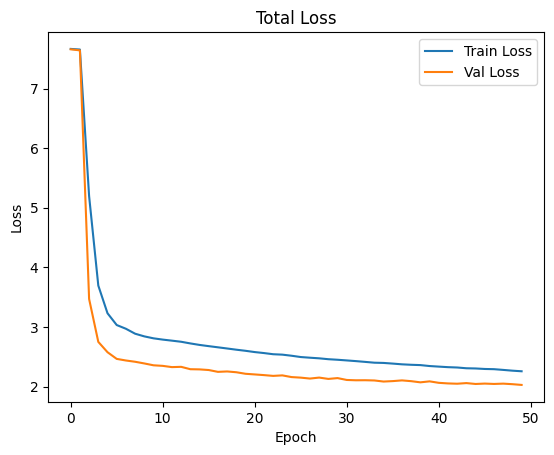

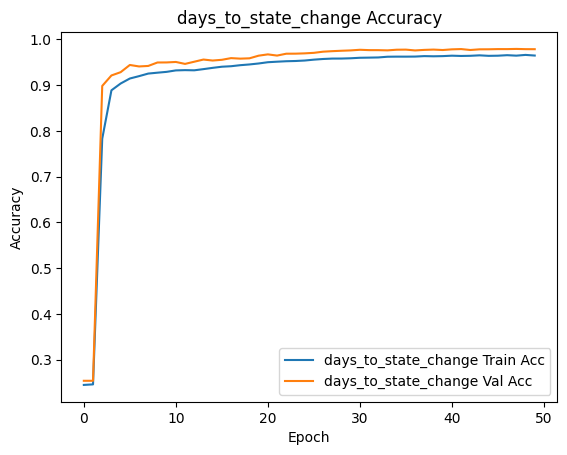

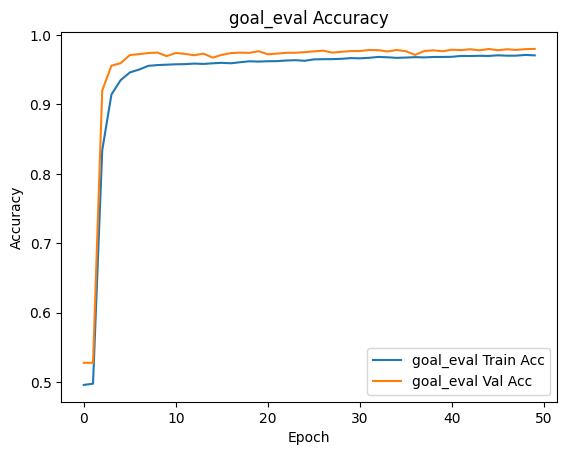

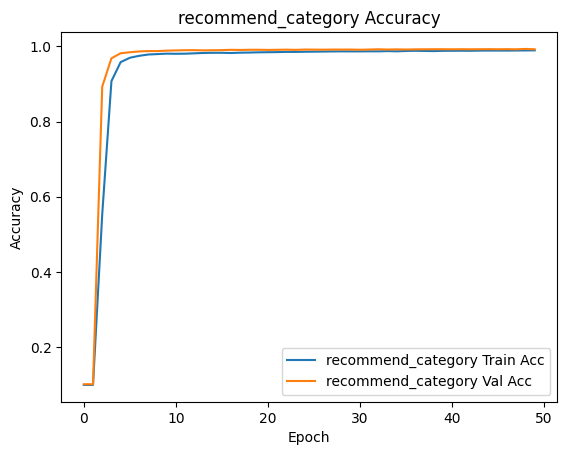

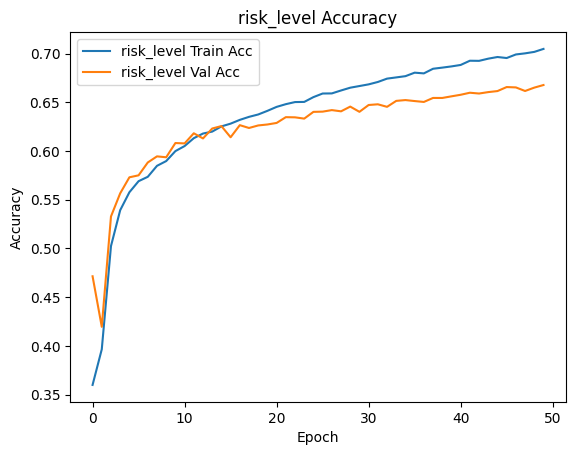

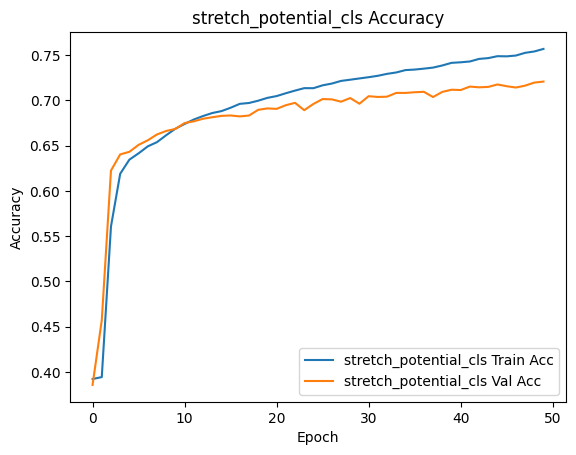

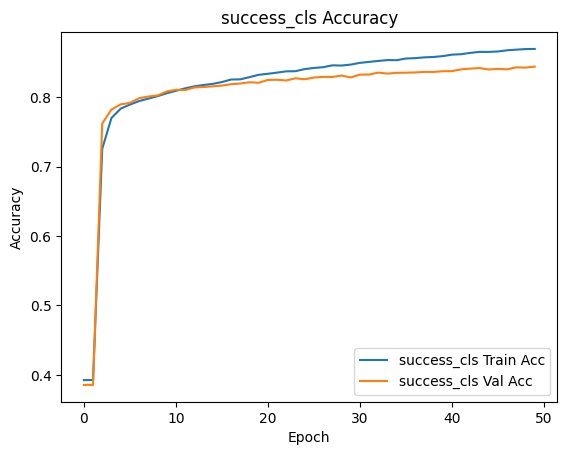

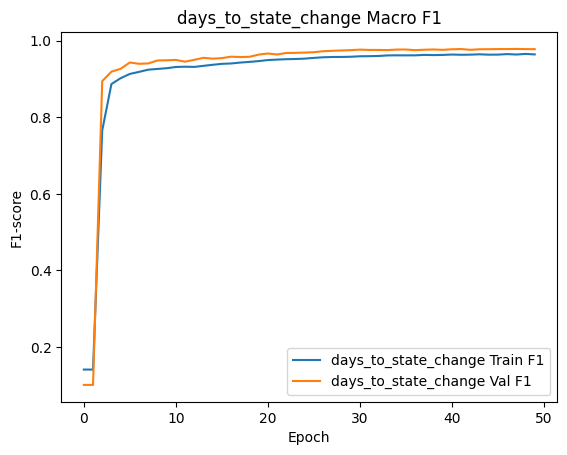

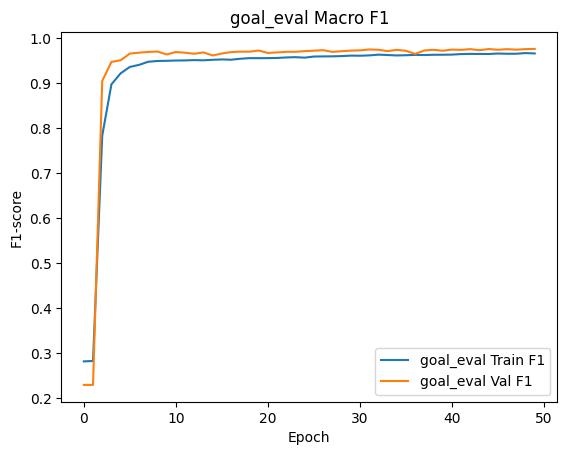

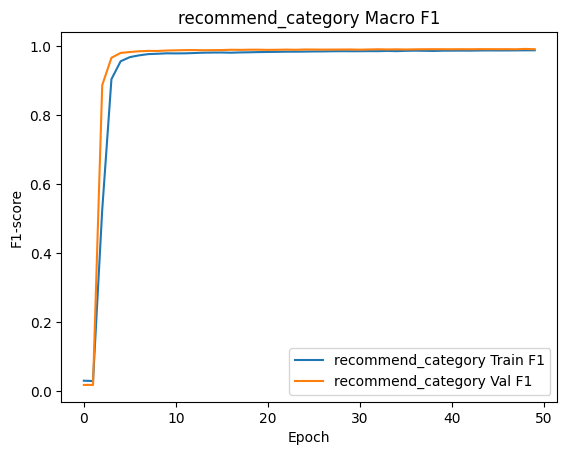

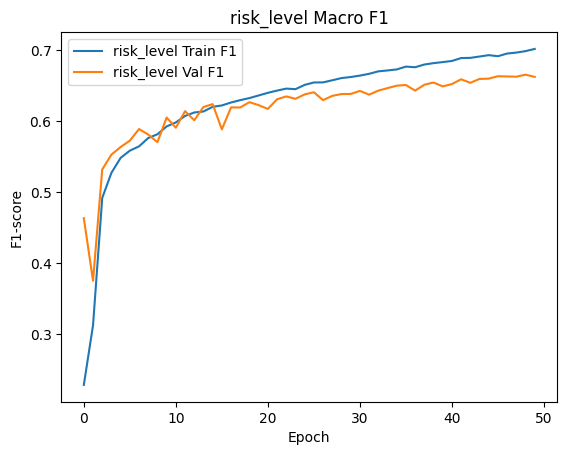

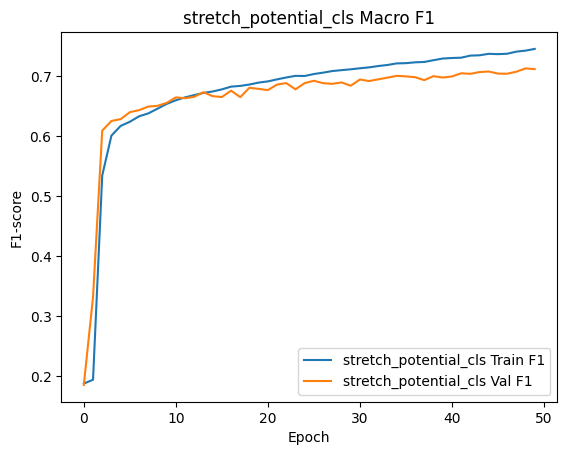

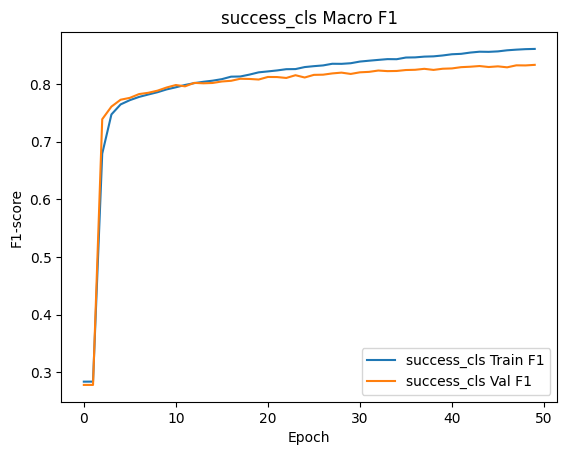

In [ ]:

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

for head in history["train_acc"]:
    plt.figure()
    plt.plot(history["train_acc"][head], label=f"{head} Train Acc")
    plt.plot(history["val_acc"][head], label=f"{head} Val Acc")
    plt.legend()
    plt.title(f"{head} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

for head in history["train_f1"]:
    plt.figure()
    plt.plot(history["train_f1"][head], label=f"{head} Train F1")
    plt.plot(history["val_f1"][head], label=f"{head} Val F1")
    plt.legend()
    plt.title(f"{head} Macro F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.show()
